In [1]:
# Step 1: Project Setup and Configuration

# --- Core Libraries & Data Handling ---
import os
import re
import gc
import json
import pickle
import psutil
import warnings
import hashlib
import polars as pl
import pandas as pd
import numpy as np
import regex as re
from pathlib import Path
from functools import lru_cache
from types import SimpleNamespace
from collections import defaultdict
from dotenv import load_dotenv

# --- Machine Learning & Deep Learning ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer

# --- Vector Search & Similarity ---
import faiss
import jellyfish
import networkx as nx

# --- Visualization & Optimization ---
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from tqdm import tqdm

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# Load environment variables from .env (for RAW_DATA_DIR, PROCESSED_DATA_DIR, etc.)
load_dotenv()

# ==============================================================================
#  Execution Control - Skip expensive operations if results are already saved
# ==============================================================================
SKIP_HYPERPARAMETER_OPTIMIZATION = False  # Skips Optuna HPO (~10 minutes)
SKIP_MODEL_TRAINING = False              # Set to True to skip the final model training
SKIP_FAISS_INDEXING = False             # Skips creating the FAISS index (~2-3 minutes)
RAW_DATA_DIR = Path(os.getenv("RAW_DATA_DIR", "./data/"))
PROCESSED_DATA_DIR = Path(os.getenv("PROCESSED_DATA_DIR", "./data/processed/"))

print("="*60)
print("EXECUTION CONTROL FLAGS")
print("="*60)
print(f"Skip Hyperparameter Optimization: {SKIP_HYPERPARAMETER_OPTIMIZATION}")
print(f"Skip Model Training: {SKIP_MODEL_TRAINING}")
print(f"Skip FAISS Indexing: {SKIP_FAISS_INDEXING}")
print(f"RAW_DATA_DIR: {RAW_DATA_DIR}")
print(f"PROCESSED_DATA_DIR: {PROCESSED_DATA_DIR}")
print("="*60)

# Set a seed for reproducibility across all libraries
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Central configuration class for all project parameters
class ProjectConfig:
    """Holds all key configuration parameters for the project."""
    DATA_DIR = RAW_DATA_DIR
    MIN_USER_RATINGS = 5
    MIN_BOOK_RATINGS = 10
    EMBEDDING_DIM = 64
    LOSS_TYPE = 'bce'
    RATING_THRESHOLD_BCE = 7
    TEST_SIZE = 0.2
    BATCH_SIZE = 1024
    LEARNING_RATE = 1e-3
    EPOCHS = 10

    # --- Device Configuration ---
    # Automatically select the best available device: CUDA > MPS > CPU
    if torch.cuda.is_available():
        DEVICE = "cuda"
    elif torch.backends.mps.is_available():
        DEVICE = "mps"
    else:
        DEVICE = "cpu"

CONFIG = ProjectConfig()

print(f"\nProject Configuration Initialized:")
print(f"  - Device for training: {CONFIG.DEVICE.upper()}")
print(f"  - Loss function: {CONFIG.LOSS_TYPE.upper()}")

/Users/vahid/Downloads/fedshi/Fedshi_mla/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/vahid/Downloads/fedshi/Fedshi_mla/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EXECUTION CONTROL FLAGS
Skip Hyperparameter Optimization: False
Skip Model Training: False
Skip FAISS Indexing: False
RAW_DATA_DIR: data
PROCESSED_DATA_DIR: data/processed

Project Configuration Initialized:
  - Device for training: MPS
  - Loss function: BCE


In [2]:
# Step 2: Data Loading

print("--- Loading raw datasets from CSV files ---")

try:
    # Define common parameters for CSV reading to handle potential parsing issues
    common_params = {
        'separator': ',',
        'has_header': True,
        'encoding': 'ISO-8859-1', # Common encoding for this dataset
        'quote_char': '"',
        'ignore_errors': True 
    }

    books = pl.read_csv(CONFIG.DATA_DIR / "Books.csv", **common_params)
    users = pl.read_csv(CONFIG.DATA_DIR / "Users.csv", **common_params)
    ratings = pl.read_csv(CONFIG.DATA_DIR / "Ratings.csv", **common_params)

    print("\n--- All Data Loaded Successfully ---")
    print(f"Books shape: {books.shape}")
    print(f"Users shape: {users.shape}")
    print(f"Ratings shape: {ratings.shape}")

except Exception as e:
    print(f"\nAn error occurred during data loading: {e}")

--- Loading raw datasets from CSV files ---

--- All Data Loaded Successfully ---
Books shape: (271360, 8)
Users shape: (278858, 3)
Ratings shape: (1149780, 3)


In [3]:
# Step 3: Column Name Standardization

def standardize_cols(df: pl.DataFrame) -> pl.DataFrame:
    """Converts all column names to lowercase snake_case for consistency."""
    return df.rename({col: col.lower().replace('-', '_').replace(' ', '_') for col in df.columns})

# Apply the standardization to all dataframes
books = standardize_cols(books)
users = standardize_cols(users)
ratings = standardize_cols(ratings)

print("--- Column Names Standardized ---")
print(f"Books columns: {books.columns}")
print(f"Users columns: {users.columns}")
print(f"Ratings columns: {ratings.columns}")

--- Column Names Standardized ---
Books columns: ['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l']
Users columns: ['user_id', 'location', 'age']
Ratings columns: ['user_id', 'isbn', 'book_rating']


In [4]:
# Step 4: Column Renaming

print("--- Renaming columns for clarity and brevity ---")

rename_book_map = {
    "book_title": "title",
    "book_author": "author",
    "year_of_publication": "yop",
    "image_url_s": "image_s",
    "image_url_m": "image_m",
    "image_url_l": "image_l"
}
rename_rating_map = {
    "book_rating": "rating"
}
rename_users_map = {
    "location": "loc",
}

def rename_columns(df: pl.DataFrame, rename_dict: dict) -> pl.DataFrame:
    """A simple helper to apply a renaming dictionary to a dataframe."""
    return df.rename(rename_dict)

books = rename_columns(books, rename_book_map)
ratings = rename_columns(ratings, rename_rating_map)
users = rename_columns(users, rename_users_map)

print("\n--- Columns Renamed ---")
print(f"Books columns: {books.columns}")
print(f"Users columns: {users.columns}")
print(f"Ratings columns: {ratings.columns}")

--- Renaming columns for clarity and brevity ---

--- Columns Renamed ---
Books columns: ['isbn', 'title', 'author', 'yop', 'publisher', 'image_s', 'image_m', 'image_l']
Users columns: ['user_id', 'loc', 'age']
Ratings columns: ['user_id', 'isbn', 'rating']


In [5]:
# Step 5: Duplicate Data Handling

print("--- Removing Duplicate Entries ---")

def remove_duplicates(df: pl.DataFrame, subset_cols: list[str], df_name: str) -> pl.DataFrame:
    """Checks for and removes duplicate rows based on a subset of columns."""
    print(f"\nChecking for duplicates in '{df_name}' based on {subset_cols}...")
    
    initial_rows = df.shape[0]
    df_cleaned = df.unique(subset=subset_cols, keep='first')
    final_rows = df_cleaned.shape[0]
    duplicates_removed = initial_rows - final_rows
    
    if duplicates_removed > 0:
        print(f"  > Found and removed {duplicates_removed} duplicate row(s).")
    else:
        print("  > No duplicate rows found.")
        
    print(f"  Original shape: ({initial_rows}, {df.shape[1]}) -> New shape: ({final_rows}, {df_cleaned.shape[1]})")
    return df_cleaned

# Check each dataframe for its primary key uniqueness
books = remove_duplicates(df=books, subset_cols=['isbn'], df_name='books')
users = remove_duplicates(df=users, subset_cols=['user_id'], df_name='users')
ratings = remove_duplicates(df=ratings, subset_cols=['user_id', 'isbn'], df_name='ratings')

--- Removing Duplicate Entries ---

Checking for duplicates in 'books' based on ['isbn']...
  > No duplicate rows found.
  Original shape: (271360, 8) -> New shape: (271360, 8)

Checking for duplicates in 'users' based on ['user_id']...
  > No duplicate rows found.
  Original shape: (278858, 3) -> New shape: (278858, 3)

Checking for duplicates in 'ratings' based on ['user_id', 'isbn']...
  > No duplicate rows found.
  Original shape: (1149780, 3) -> New shape: (1149780, 3)


In [6]:
# Step 6: Cleaning Author Data

print("--- Cleaning the 'author' Column with Diagnostics ---")

# Diagnostic: Analyze author data BEFORE cleaning
total_books_before = books.shape[0]
null_authors_before = books.filter(pl.col("author").is_null()).shape[0]
na_authors_before = books.filter(pl.col("author") == "n/a").shape[0]
not_applicable_authors_before = books.filter(pl.col("author") == "Not Applicable (Na )").shape[0]
total_to_clean = null_authors_before + na_authors_before + not_applicable_authors_before

print("\n--- Before Cleaning ---")
print(f"Total book records: {total_books_before}")
print(f" - Null authors: {null_authors_before}")
print(f" - 'n/a' authors: {na_authors_before}")
print(f" - 'Not Applicable (Na )' authors: {not_applicable_authors_before}")
print(f"-------------------------------------------")
print(f"Total authors to be replaced: {total_to_clean}")

# The Cleaning Operation: Replace various null-like values with a standard 'Unknown Author'
books = books.with_columns(
    pl.when(
        pl.col("author").is_null() |
        (pl.col("author") == "n/a") |
        (pl.col("author") == "Not Applicable (Na )")
    )
    .then(pl.lit("Unknown Author"))
    .otherwise(pl.col("author"))
    .alias("author")
)

# Diagnostic: Verify the results AFTER cleaning
unknown_author_count = books.filter(pl.col("author") == "Unknown Author").shape[0]
null_authors_after = books.filter(pl.col("author").is_null()).shape[0]

print("\n--- After Cleaning ---")
print(f"Total rows with author as 'Unknown Author': {unknown_author_count}")
print(f"Verification: Null authors remaining: {null_authors_after}")

if total_to_clean == unknown_author_count:
    print("\nSuccess: The number of 'Unknown Author' rows matches the number of rows that needed cleaning.")
else:
    print("\nWarning: Mismatch in counts. Please review the cleaning logic.")

--- Cleaning the 'author' Column with Diagnostics ---

--- Before Cleaning ---
Total book records: 271360
 - Null authors: 1
 - 'n/a' authors: 0
 - 'Not Applicable (Na )' authors: 286
-------------------------------------------
Total authors to be replaced: 287

--- After Cleaning ---
Total rows with author as 'Unknown Author': 287
Verification: Null authors remaining: 0

Success: The number of 'Unknown Author' rows matches the number of rows that needed cleaning.


In [7]:
# Step 7: Advanced Book Deduplication

print("--- Performing Optimized Book Deduplication ---")

# This cell identifies different editions of the same conceptual 'work' 
# and assigns them a unique 'work_id'. This is crucial for the recommendation model.

JUNK_CHAR_PATTERN = re.compile(r'[^\p{L}\p{N}\s]')
JUNK_COUNT_THRESHOLD = 3

def clean_and_assess_title(title: str):
    """Applies advanced cleaning rules and counts junk characters."""
    if not isinstance(title, str):
        return {"title_leading_cleaned": "", "junk_count": 0}

    junk_count = len(JUNK_CHAR_PATTERN.findall(title))
    match = re.search(r'[\p{L}\p{N}]', title)
    title_leading_cleaned = title[match.start():] if match else ""
    return {"title_leading_cleaned": title_leading_cleaned, "junk_count": int(junk_count)}

print("Applying advanced junk character rules...")
books = books.with_columns(pl.col("title").cast(pl.Utf8))

# 1. Add helper columns for junk count and cleaned title
books = books.with_columns(
    pl.col("title").map_elements(
        clean_and_assess_title,
        return_dtype=pl.Struct([
            pl.Field("title_leading_cleaned", pl.Utf8),
            pl.Field("junk_count", pl.Int64),
        ])
    ).alias("cleaned_data")
).unnest("cleaned_data")

# 2. Filter the DataFrame directly based on the new junk_count column
initial_count = books.shape[0]
books = books.filter(pl.col("junk_count") <= JUNK_COUNT_THRESHOLD)
dropped_count = initial_count - books.shape[0]
print(f"Dropped {dropped_count} books for exceeding junk character threshold of {JUNK_COUNT_THRESHOLD}.")

# 3. Update the 'title' column with the cleaner version and drop helper columns
books = books.with_columns(
    pl.col("title_leading_cleaned").alias("title")
).drop(["title_leading_cleaned", "junk_count"])


SIMILARITY_THRESHOLD = 0.95
TITLE_CLEANUP_PATTERN = re.compile(r'\s*[\(\[].*?[\)\]]\s*')
WHITESPACE_PATTERN = re.compile(r'\s+')
EDITION_KEYWORDS = {'paperback', 'hardcover', 'annotated', 'illustrated', 'edition'}

def repair_text_encoding(text: str) -> str:
    if not isinstance(text, str): return ""
    try: return text.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError): return text

def normalize_author(author: str) -> str:
    if not isinstance(author, str): return ""
    author = repair_text_encoding(author).lower()
    if ',' in author:
        parts = [p.strip() for p in author.split(',')]; author = f"{parts[1]} {parts[0]}" if len(parts) > 1 else parts[0]
    author = author.replace('.', ''); author = WHITESPACE_PATTERN.sub(' ', author).strip()
    return author

def normalize_title(title: str) -> str:
    if not isinstance(title, str): return ""
    title = repair_text_encoding(title).lower()
    title = TITLE_CLEANUP_PATTERN.sub(' ', title).strip()
    title = title.split(':')[0].strip()
    for keyword in EDITION_KEYWORDS:
        title = title.replace(keyword, '')
    title = JUNK_CHAR_PATTERN.sub('', title)
    title = WHITESPACE_PATTERN.sub(' ', title).strip()
    return title

def get_title_clusters_optimized(titles: list[str], threshold: float) -> dict[str, int]:
    if not titles: return {}
    unique_titles = list(set(titles))
    if len(unique_titles) <= 1: return {unique_titles[0]: 0} if unique_titles else {}
    parent = {title: title for title in unique_titles}
    def find(x):
        if parent[x] != x: parent[x] = find(parent[x])
        return parent[x]
    def union(x, y):
        px, py = find(x), find(y)
        if px != py: parent[px] = py
    n = len(unique_titles)
    for i in range(n):
        for j in range(i + 1, n):
            title1, title2 = unique_titles[i], unique_titles[j]
            if jellyfish.jaro_winkler_similarity(title1, title2) >= threshold:
                union(title1, title2)
    clusters = {}; cluster_id = 0
    for title in unique_titles:
        root = find(title)
        if root not in clusters: clusters[root] = cluster_id; cluster_id += 1
        clusters[title] = clusters[root]
    return clusters

print("Applying optimized normalization for clustering...")
books = books.with_columns(pl.col("author").cast(pl.Utf8), pl.col("title").cast(pl.Utf8))
books_temp = books.with_columns([
    pl.col("author").map_elements(normalize_author, return_dtype=pl.Utf8).alias("normalized_author"),
    pl.col("title").map_elements(normalize_title, return_dtype=pl.Utf8).alias("normalized_title")
])
print("Grouping by normalized_author and clustering...")
author_groups = books_temp.group_by("normalized_author").agg(pl.col("normalized_title").unique())
cluster_results = []
for norm_author, titles_list in tqdm(author_groups.iter_rows(), total=len(author_groups)):
    title_to_cluster = get_title_clusters_optimized(titles_list, SIMILARITY_THRESHOLD)
    for norm_title, cluster_id in title_to_cluster.items():
        unique_cluster_id = f"{norm_author}_{cluster_id}"
        cluster_results.append({"normalized_title": norm_title, "normalized_author": norm_author, "cluster_id": unique_cluster_id})
cluster_df = pl.DataFrame(cluster_results)
print("Assigning cluster IDs...")
books_with_clusters = books_temp.join(cluster_df, on=["normalized_title", "normalized_author"], how="left")
books_with_clusters = books_with_clusters.with_columns(
    pl.when(pl.col("cluster_id").is_null())
      .then(pl.col("normalized_title") + "_" + pl.col("normalized_author"))
      .otherwise(pl.col("cluster_id"))
      .alias("cluster_id")
)
author_counts = books_with_clusters.group_by(["cluster_id", "author"]).agg(pl.count().alias("cnt"))
max_author_counts = author_counts.group_by("cluster_id").agg(pl.col("cnt").max().alias("max_cnt"))
author_top = author_counts.join(max_author_counts, on="cluster_id").filter(pl.col("cnt") == pl.col("max_cnt"))
author_top = author_top.with_columns(pl.col("author").map_elements(lambda s: len(s) if s else 0, return_dtype=pl.Int64).alias("alen"))
author_top = author_top.sort(["cluster_id", "alen"], descending=[False, False]).group_by("cluster_id", maintain_order=True).first().select(["cluster_id", pl.col("author").alias("canonical_author")])
canonical_authors = author_top
title_counts = books_with_clusters.group_by(["cluster_id", "title"]).agg(pl.count().alias("cnt"))
max_title_counts = title_counts.group_by("cluster_id").agg(pl.col("cnt").max().alias("max_cnt"))
title_top = title_counts.join(max_title_counts, on="cluster_id").filter(pl.col("cnt") == pl.col("max_cnt"))
title_top = title_top.with_columns(pl.col("title").map_elements(lambda s: len(s) if s else 0, return_dtype=pl.Int64).alias("tlen"))
title_top = title_top.sort(["cluster_id", "tlen"], descending=[False, False]).group_by("cluster_id", maintain_order=True).first().select(["cluster_id", pl.col("title").alias("representative_title")])
representative_titles = title_top
works_meta = canonical_authors.join(representative_titles.rename({"representative_title": "rep_title"}), on="cluster_id", how="left")
works_meta = works_meta.with_row_count(name="work_id")
print("Enriching and forcing canonical_title from original title...")
books_final = books_with_clusters.join(works_meta, on="cluster_id", how="left")
books_final = books_final.with_columns(
    pl.col("title").map_elements(lambda s: (repair_text_encoding(s).split('(', 1)[0].strip()) if isinstance(s, str) else "", return_dtype=pl.Utf8).alias("canonical_title")
)
books_final = books_final.with_columns(pl.when(pl.col("canonical_author").is_null()).then(pl.col("author")).otherwise(pl.col("canonical_author")).alias("canonical_author"))
final_cols = ['isbn', 'title', 'author', 'yop', 'publisher', 'work_id', 'canonical_title', 'canonical_author', 'image_s', 'image_m', 'image_l']
books_final = books_final.select([c for c in final_cols if c in books_final.columns])
isbn_to_work_id = books_final.select(["isbn", "work_id"])
initial_book_count_after_filter = books.shape[0]
final_book_count = books_final.shape[0]
print(f"\nVerification: Book count after initial filter: {initial_book_count_after_filter}, Final book count: {final_book_count}")
if initial_book_count_after_filter != final_book_count:
    print("ERROR: Rows were lost during enrichment!")
else:
    print("Success: The enrichment process was lossless.")
books = books_final
print("\nDeduplication and enrichment complete.")

--- Performing Optimized Book Deduplication ---
Applying advanced junk character rules...
Dropped 38343 books for exceeding junk character threshold of 3.
Applying optimized normalization for clustering...
Grouping by normalized_author and clustering...


100%|██████████| 88936/88936 [00:02<00:00, 31637.58it/s]


Assigning cluster IDs...
Enriching and forcing canonical_title from original title...

Verification: Book count after initial filter: 233017, Final book count: 233017
Success: The enrichment process was lossless.

Deduplication and enrichment complete.


In [8]:
# Step 8: Filtering Implicit Ratings

print("--- Filtering Out Implicit Feedback (Zero Ratings) ---")

# In this dataset, a rating of 0 indicates the user read the book but provided no explicit rating.
# For a collaborative filtering model based on explicit feedback, we remove these.
initial_rows = ratings.shape[0]
print(f"Total ratings before filtering: {initial_rows}")

# The Filtering Operation
ratings = ratings.filter(pl.col("rating") > 0)

final_rows = ratings.shape[0]
rows_removed = initial_rows - final_rows
percent_removed = (rows_removed / initial_rows) * 100

print(f"> Removed {rows_removed} zero-rating rows ({percent_removed:.2f}% of the total).")
print(f"Total explicit ratings remaining: {final_rows}")

print("\n'ratings' DataFrame now contains only explicit ratings (1-10).")

--- Filtering Out Implicit Feedback (Zero Ratings) ---
Total ratings before filtering: 1149780
> Removed 716109 zero-rating rows (62.28% of the total).
Total explicit ratings remaining: 433671

'ratings' DataFrame now contains only explicit ratings (1-10).


In [9]:
# Step 9: Consolidating Ratings by Work ID

print("--- Mapping Ratings to Master Works and Aggregating Interaction Data ---")

# 1. Map ratings from the original ISBN to our new integer work_id
ratings = ratings.join(isbn_to_work_id, on="isbn", how="inner")

initial_ratings_count = len(ratings)
print(f"Mapped ratings to work_ids. Total interactions to process: {initial_ratings_count}")

# 2. Consolidate ratings and count interactions
# We group by user and work_id to handle cases where a user rated multiple editions of the same work.
ratings_consolidated = ratings.group_by(["user_id", "work_id"]).agg(
    pl.col("rating").max().alias("rating"),           # Strategy: Keep the user's highest rating for that work
    pl.count().alias("rating_count")                  # Also, count how many editions they interacted with
)

final_ratings_count = len(ratings_consolidated)
ratings_removed = initial_ratings_count - final_ratings_count

print(f"\nConsolidated ratings for duplicate book editions.")
print(f"Collapsed {initial_ratings_count} raw interactions into {final_ratings_count} unique user-work interactions.")
print(f"Redundant interactions removed: {ratings_removed}")

# Overwrite with the final, clean ratings table
ratings = ratings_consolidated

print(f"\nFinal 'ratings' DataFrame now includes 'rating_count' for potential weighting.")
print("\nExample of users with high interaction counts for a single work:")
print(ratings.filter(pl.col("rating_count") > 1).sort("rating_count", descending=True).head())

--- Mapping Ratings to Master Works and Aggregating Interaction Data ---
Mapped ratings to work_ids. Total interactions to process: 334993

Consolidated ratings for duplicate book editions.
Collapsed 334993 raw interactions into 332709 unique user-work interactions.
Redundant interactions removed: 2284

Final 'ratings' DataFrame now includes 'rating_count' for potential weighting.

Example of users with high interaction counts for a single work:
shape: (5, 4)
┌─────────┬─────────┬────────┬──────────────┐
│ user_id ┆ work_id ┆ rating ┆ rating_count │
│ ---     ┆ ---     ┆ ---    ┆ ---          │
│ i64     ┆ u32     ┆ i64    ┆ u32          │
╞═════════╪═════════╪════════╪══════════════╡
│ 78973   ┆ 54087   ┆ 7      ┆ 10           │
│ 94242   ┆ 150972  ┆ 9      ┆ 10           │
│ 209464  ┆ 136567  ┆ 10     ┆ 9            │
│ 156111  ┆ 104991  ┆ 10     ┆ 9            │
│ 63714   ┆ 132713  ┆ 10     ┆ 8            │
└─────────┴─────────┴────────┴──────────────┘


In [10]:
# Step 10: User Feature Engineering

def engineer_user_age_quantile_bins(df: pl.DataFrame, n_quantiles: int = 8) -> pl.DataFrame:
    """
    Converts the continuous 'age' column into discrete bins based on quantiles.
    This method is data-driven, ensuring each bin has a similar number of users.
    """
    print(f"Engineering 'age' into {n_quantiles} quantile-based bins...")

    # Ensure age is numeric, coercing errors to null
    df = df.with_columns(pl.col("age").cast(pl.Float64, strict=False))

    # Separate users with and without age data
    known_age_df = df.filter(pl.col("age").is_not_null())
    unknown_age_df = df.filter(pl.col("age").is_null())

    # Use qcut to create quantile bins for users with known age
    known_age_df = known_age_df.with_columns(
        pl.col("age").qcut(n_quantiles, labels=[f"q{i+1}" for i in range(n_quantiles)]).alias("age_bin")
    )
    
    # Assign a dedicated 'Unknown' category for the rest
    unknown_age_df = unknown_age_df.with_columns(
        pl.lit("Unknown").cast(pl.Categorical).alias("age_bin")
    )

    # Combine the dataframes back together
    final_df = pl.concat([known_age_df, unknown_age_df])

    # Display diagnostics about the created bins
    age_ranges = final_df.group_by("age_bin").agg(
        count=pl.count(),
        min_age_in_bin=pl.col("age").min(),
        max_age_in_bin=pl.col("age").max()
    ).sort("age_bin")
    
    print("\nDistribution of Quantile Age Bins:")
    print(age_ranges)

    # Drop the original age column
    return final_df.drop("age")

def safe_get(lst, index, default=None):
    """Safely gets an element from a list by index, stripping whitespace."""
    try:
        element = lst[index]
        return element.strip() if element else default
    except (IndexError, AttributeError):
        return default

def engineer_user_location(df: pl.DataFrame) -> pl.DataFrame:
    """Parses the 'loc' string into city, state, and country columns."""
    print("\nEngineering location features (city, state, country)...")
    df_with_parts = df.with_columns(pl.col("loc").str.split(by=",").alias("loc_parts"))
    return df_with_parts.with_columns(
        pl.col("loc_parts").map_elements(lambda lst: safe_get(lst, -1), return_dtype=pl.String).alias("country"),
        pl.col("loc_parts").map_elements(lambda lst: safe_get(lst, -2), return_dtype=pl.String).alias("state"),
        pl.col("loc_parts").map_elements(lambda lst: safe_get(lst, -3), return_dtype=pl.String).alias("city"),
    ).drop("loc_parts")

# --- Execute the full user data processing pipeline ---
users = users.pipe(engineer_user_age_quantile_bins).pipe(engineer_user_location)

print("\n--- Final Cleaned Users DataFrame ---")
print(users.head())

Engineering 'age' into 8 quantile-based bins...

Distribution of Quantile Age Bins:
shape: (9, 4)
┌─────────┬────────┬────────────────┬────────────────┐
│ age_bin ┆ count  ┆ min_age_in_bin ┆ max_age_in_bin │
│ ---     ┆ ---    ┆ ---            ┆ ---            │
│ cat     ┆ u32    ┆ f64            ┆ f64            │
╞═════════╪════════╪════════════════╪════════════════╡
│ Unknown ┆ 110762 ┆ null           ┆ null           │
│ q1      ┆ 24019  ┆ 0.0            ┆ 20.0           │
│ q2      ┆ 20295  ┆ 21.0           ┆ 24.0           │
│ q3      ┆ 21895  ┆ 25.0           ┆ 28.0           │
│ q4      ┆ 19517  ┆ 29.0           ┆ 32.0           │
│ q5      ┆ 21027  ┆ 33.0           ┆ 37.0           │
│ q6      ┆ 21018  ┆ 38.0           ┆ 44.0           │
│ q7      ┆ 21012  ┆ 45.0           ┆ 53.0           │
│ q8      ┆ 19313  ┆ 54.0           ┆ 244.0          │
└─────────┴────────┴────────────────┴────────────────┘

Engineering location features (city, state, country)...

--- Final Cleaned U

In [11]:
# Step 11: Cleaning Book Publication Year

# 1. Clean and standardize the 'yop' (Year of Publication) column
# Coerce 'yop' to integer, making errors null
books_temp = books.with_columns(
    pl.col("yop").cast(pl.Int64, strict=False)
)
# Identify and nullify illogical years (e.g., 0 or future years)
current_year = 2024 
books_temp = books_temp.with_columns(
    pl.when((pl.col("yop") == 0) | (pl.col("yop") > current_year))
    .then(None)
    .otherwise(pl.col("yop"))
    .alias("yop")
)

# 2. Diagnostic Check for Year of Publication
print("\n--- Diagnostic Check for 'yop' Column ---")
total_books = len(books_temp)
missing_yop = books_temp['yop'].is_null().sum()
missing_yop_pct = (missing_yop / total_books) * 100

print(f"Total book records: {total_books}")
print(f"Number of books with missing yop: {missing_yop}")
print(f"Percentage of books with missing yop: {missing_yop_pct:.2f}%")

# 3. Imputation Strategy
# Since the percentage of missing yop is low, median imputation is a safe choice.
YOP_MISSING_THRESHOLD = 50.0 
if missing_yop_pct > YOP_MISSING_THRESHOLD:
    print(f"\nDecision: Missing yop percentage ({missing_yop_pct:.2f}%) is too high. Dropping the 'yop' column.")
    books = books_temp.drop("yop")
else:
    print(f"\nDecision: Missing yop percentage ({missing_yop_pct:.2f}%) is acceptable. Proceeding with median imputation.")
    median_year = books_temp["yop"].median()
    print(f"Median year for imputation: {median_year:.0f}")
    books = books_temp.with_columns(
        pl.col("yop").fill_null(median_year).cast(pl.Int32)
    )

print("\n--- 'yop' column cleaned and imputed. ---")


--- Diagnostic Check for 'yop' Column ---
Total book records: 233017
Number of books with missing yop: 4548
Percentage of books with missing yop: 1.95%

Decision: Missing yop percentage (1.95%) is acceptable. Proceeding with median imputation.
Median year for imputation: 1995

--- 'yop' column cleaned and imputed. ---



Visualizing user distribution by engineered age bins...


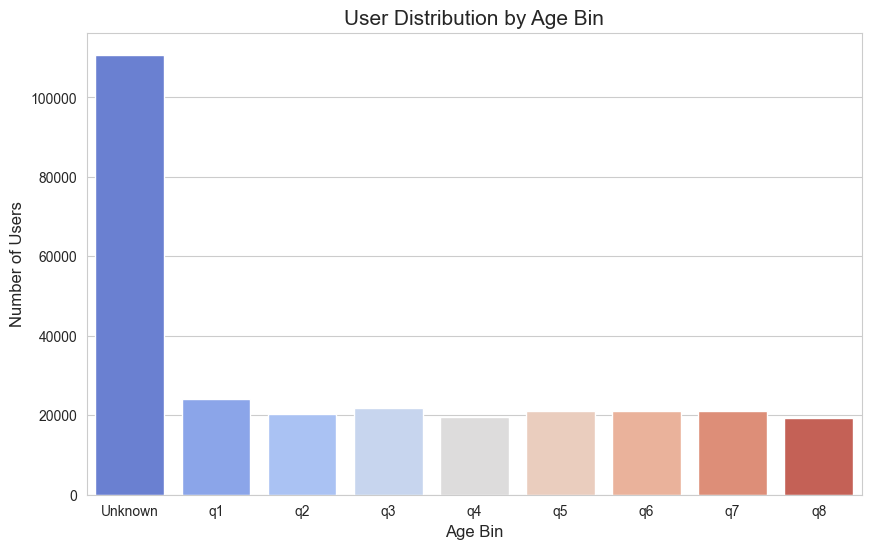


Visualizing user distribution by top 15 countries...


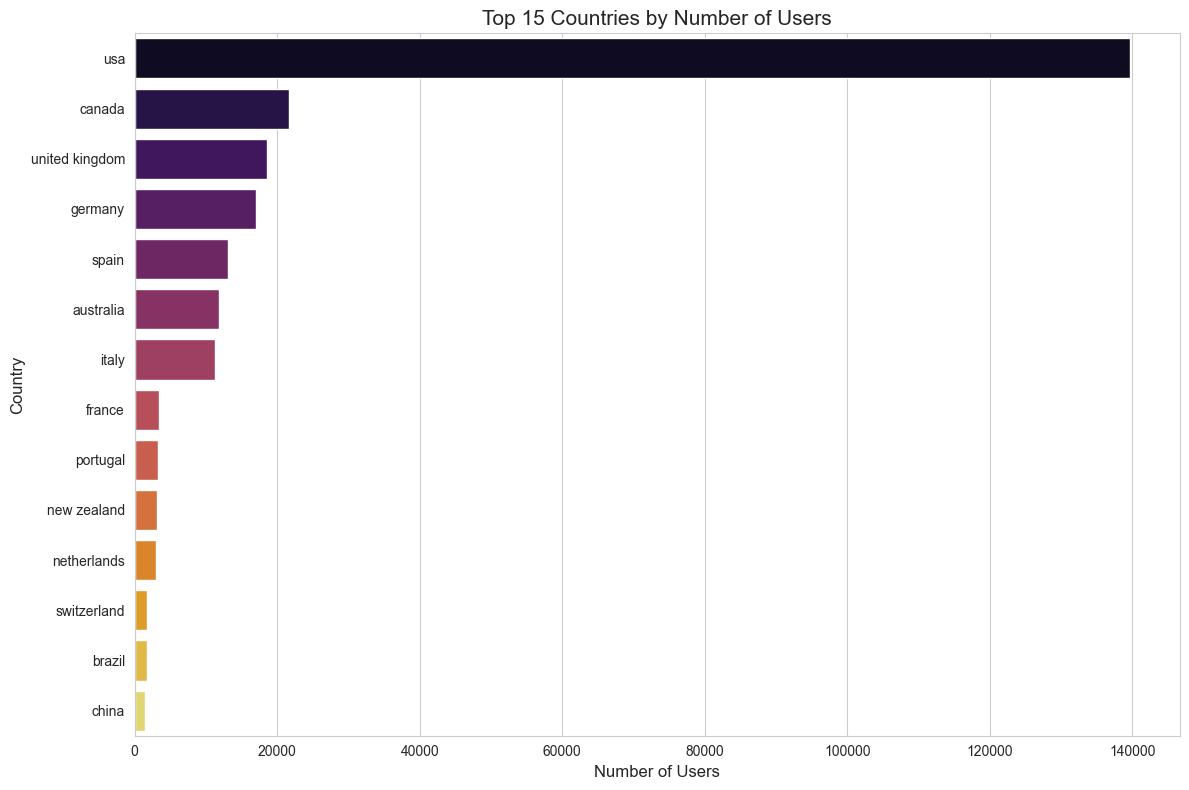

In [12]:
# Step 12: Visualizing User Demographics

sns.set_style("whitegrid")

# Plotting User Distribution by Age Bin
print("\nVisualizing user distribution by engineered age bins...")
age_bin_counts = users['age_bin'].value_counts().sort("age_bin")
plt.figure(figsize=(10, 6))
sns.barplot(x=age_bin_counts['age_bin'], y=age_bin_counts['count'], palette="coolwarm")
plt.title('User Distribution by Age Bin', fontsize=15)
plt.xlabel('Age Bin', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.show()

# Plotting User Distribution by Top 15 Countries
print("\nVisualizing user distribution by top 15 countries...")
top_countries = users['country'].value_counts().sort('count', descending=True).head(15)
plt.figure(figsize=(12, 8))
sns.barplot(y=top_countries['country'], x=top_countries['count'], palette="inferno", orient='h')
plt.title('Top 15 Countries by Number of Users', fontsize=15)
plt.xlabel('Number of Users', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

--- Visualizing the Enriched and Deduplicated Book Catalog ---

Visualizing unique work distribution by Year of Publication...


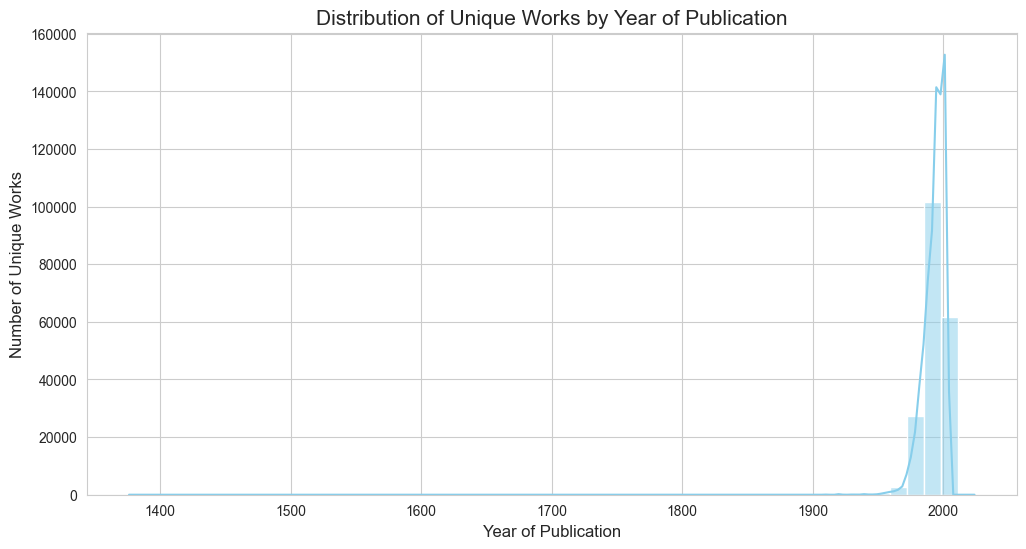


Visualizing top 15 authors by number of unique conceptual works...


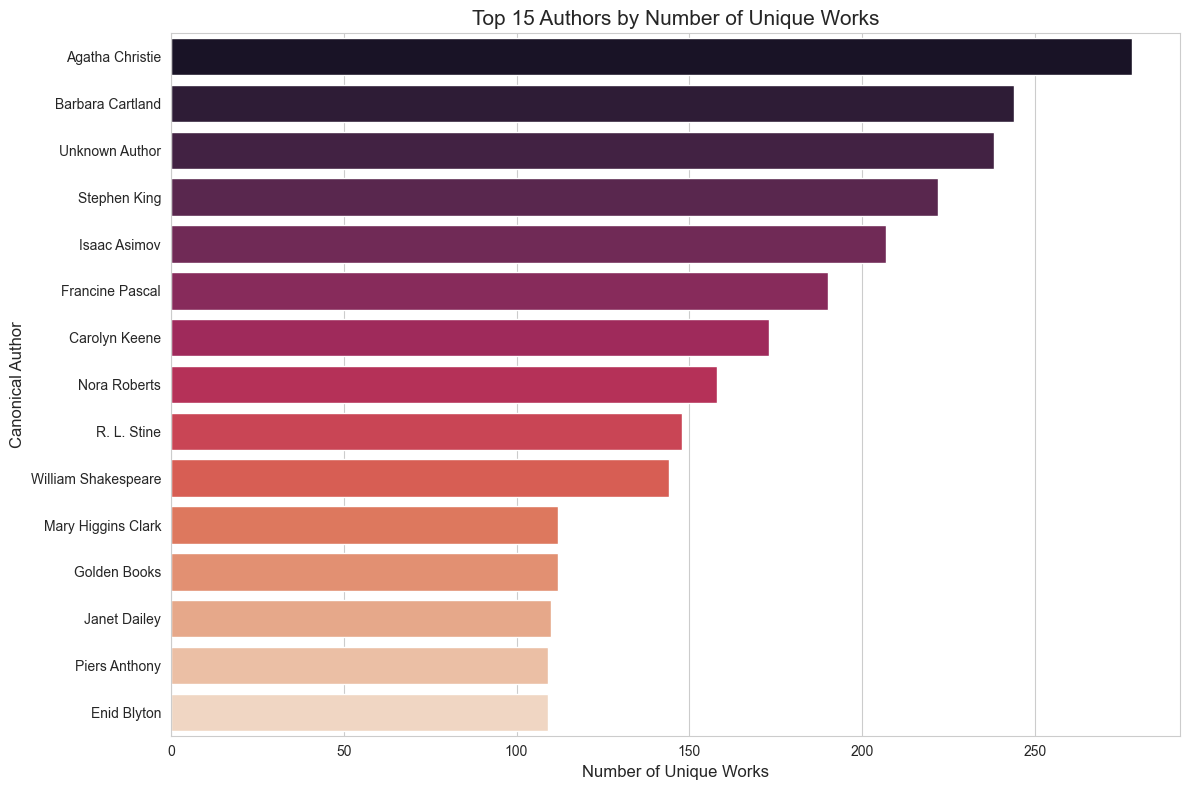


Visualizing top 15 publishers by number of unique conceptual works...


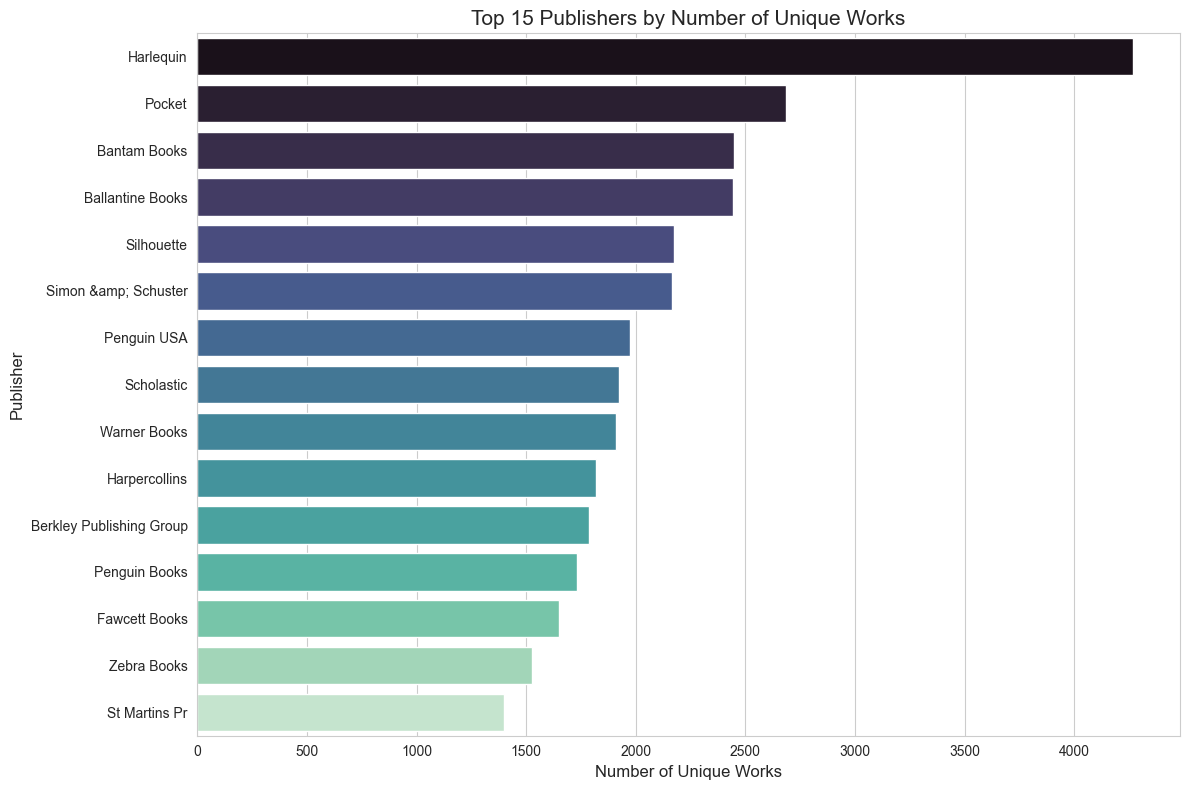

In [13]:
# Step 13: Visualizing the Book Catalog

print("--- Visualizing the Enriched and Deduplicated Book Catalog ---")

sns.set_style("whitegrid")

# Create a DataFrame of unique works to prevent over-counting due to multiple editions
unique_works = books.unique(subset=['work_id'])

# Plotting Unique Work Distribution by Year of Publication
print("\nVisualizing unique work distribution by Year of Publication...")
plt.figure(figsize=(12, 6))
sns.histplot(data=unique_works, x='yop', bins=50, kde=True, color='skyblue')
plt.title('Distribution of Unique Works by Year of Publication', fontsize=15)
plt.xlabel('Year of Publication', fontsize=12)
plt.ylabel('Number of Unique Works', fontsize=12)
plt.show()

# Plotting Top 15 Authors by Number of Unique Works
print("\nVisualizing top 15 authors by number of unique conceptual works...")
top_authors = unique_works['canonical_author'].value_counts().sort('count', descending=True).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_authors['canonical_author'], x=top_authors['count'], palette="rocket", orient='h')
plt.title('Top 15 Authors by Number of Unique Works', fontsize=15)
plt.xlabel('Number of Unique Works', fontsize=12)
plt.ylabel('Canonical Author', fontsize=12)
plt.tight_layout()
plt.show()

# Plotting Top 15 Publishers by Number of Unique Works
print("\nVisualizing top 15 publishers by number of unique conceptual works...")
top_publishers = unique_works['publisher'].value_counts().sort('count', descending=True).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_publishers['publisher'], x=top_publishers['count'], palette="mako", orient='h')
plt.title('Top 15 Publishers by Number of Unique Works', fontsize=15)
plt.xlabel('Number of Unique Works', fontsize=12)
plt.ylabel('Publisher', fontsize=12)
plt.tight_layout()
plt.show()

--- Visualizing the Final, Cleaned Ratings Distribution ---


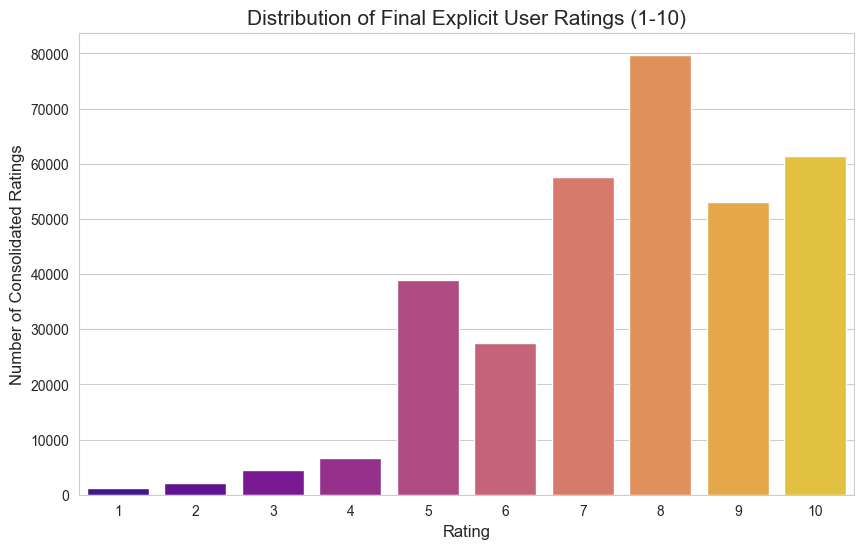

In [14]:
# Step 14: Visualizing Ratings Distribution

print("--- Visualizing the Final, Cleaned Ratings Distribution ---")

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# The 'ratings' DataFrame now only contains explicit, consolidated ratings
explicit_rating_counts = ratings['rating'].value_counts().sort("rating")
sns.barplot(x=explicit_rating_counts['rating'], y=explicit_rating_counts['count'], palette="plasma")

plt.title('Distribution of Final Explicit User Ratings (1-10)', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Consolidated Ratings', fontsize=12)
plt.show()

In [15]:
# Step 15: Creating the Final Interactions DataFrame

print("--- Unifying Data into the Final `interactions` Table ---")

# To avoid a "join explosion" from multiple book editions, we first create a
# temporary table with one unique entry per work_id.
print("Creating a temporary, unique 'works' table for joining...")
works_for_join = books.unique(subset=['work_id'], keep='first')

# Verify uniqueness as a sanity check
if works_for_join.shape[0] != works_for_join['work_id'].n_unique():
    print("CRITICAL ERROR: The temporary works table is not unique by work_id!")
else:
    print(f"Success: `works_for_join` created with {works_for_join.shape[0]} unique works.")

# Now, join our core ratings with the feature tables using 'inner' joins for data integrity.
print("\nJoining ratings, users, and works data...")
print(f"Initial ratings shape: {ratings.shape}")

interactions = ratings.join(users, on="user_id", how="inner")
print(f"Shape after joining with users: {interactions.shape}")

interactions = interactions.join(works_for_join, on="work_id", how="inner")
print(f"Final shape after joining with works: {interactions.shape}")

# Reorder columns for better readability
final_schema_cols = [
    'user_id', 'work_id', 'rating', 'rating_count', 'age_bin', 'country',
    'canonical_title', 'canonical_author', 'publisher', 'yop', 'image_m', 'image_l'
]
interactions = interactions.select([col for col in final_schema_cols if col in interactions.columns])

print("\n--- Merging Complete ---")
print(f"Final shape of the `interactions` DataFrame: {interactions.shape}")

# This map is useful later for filtering out items a user has already seen
print("\nCreating user history map (user_id -> set of work_ids)...")
user_history_df = interactions.group_by("user_id").agg(pl.col("work_id"))
user_history = {row[0]: set(row[1]) for row in user_history_df.iter_rows()}
print(f"Created history for {len(user_history)} users.")

--- Unifying Data into the Final `interactions` Table ---
Creating a temporary, unique 'works' table for joining...
Success: `works_for_join` created with 194016 unique works.

Joining ratings, users, and works data...
Initial ratings shape: (332709, 4)
Shape after joining with users: (332709, 9)
Final shape after joining with works: (332709, 19)

--- Merging Complete ---
Final shape of the `interactions` DataFrame: (332709, 12)

Creating user history map (user_id -> set of work_ids)...
Created history for 63616 users.


In [16]:
# Step 16: Sparsity Filtering and Cold Start Analysis

print("\n--- Diagnostics Before Filtering ---")
initial_interactions = interactions.shape[0]
initial_users = interactions['user_id'].n_unique()
initial_items = interactions['work_id'].n_unique()

print(f"Initial number of interactions: {initial_interactions}")
print(f"Initial number of unique users: {initial_users}")
print(f"Initial number of unique items (works): {initial_items}")

# Iteratively filter out users and items with too few interactions until the dataset stabilizes.
min_user_ratings = CONFIG.MIN_USER_RATINGS
min_book_ratings = CONFIG.MIN_BOOK_RATINGS
print(f"\nApplying filters: min {min_user_ratings} ratings/user, min {min_book_ratings} ratings/item...")

model_df = interactions
while True:
    prev_rows = model_df.shape[0]

    # Filter by user activity
    user_counts = model_df['user_id'].value_counts()
    core_users = user_counts.filter(pl.col("count") >= min_user_ratings)['user_id']
    model_df = model_df.filter(pl.col("user_id").is_in(core_users))

    # Filter by item popularity
    item_counts = model_df['work_id'].value_counts()
    core_items = item_counts.filter(pl.col("count") >= min_book_ratings)['work_id']
    model_df = model_df.filter(pl.col("work_id").is_in(core_items))

    # If no rows were removed, the dataset is stable
    if model_df.shape[0] == prev_rows:
        break

print("\n--- Diagnostics After Filtering ---")
final_interactions = model_df.shape[0]
final_users = model_df['user_id'].n_unique()
final_items = model_df['work_id'].n_unique()

print(f"Final number of interactions for the model: {final_interactions}")
print(f"Final number of unique users (core users): {final_users}")
print(f"Final number of unique items (core items): {final_items}")
print(f"\nInteractions removed: {initial_interactions - final_interactions}")
print(f"Users removed: {initial_users - final_users}")
print(f"Items removed: {initial_items - final_items}")

print("\n--- Cold Start Population Analysis ---")

# Identify users and items that did not make it into the core model dataset
all_users_set = set(users['user_id'])
all_items_set = set(books['work_id'])
core_users_set = set(model_df['user_id'])
core_items_set = set(model_df['work_id'])
cold_start_users = all_users_set - core_users_set
cold_start_items = all_items_set - core_items_set

print(f"Total users in original catalog: {len(all_users_set)}")
print(f"Users in the core model: {len(core_users_set)}")
print(f"Number of COLD START users: {len(cold_start_users)}")

print(f"\nTotal unique works in original catalog: {len(all_items_set)}")
print(f"Works in the core model: {len(core_items_set)}")
print(f"Number of COLD START items: {len(cold_start_items)}")


--- Diagnostics Before Filtering ---
Initial number of interactions: 332709
Initial number of unique users: 63616
Initial number of unique items (works): 108752

Applying filters: min 5 ratings/user, min 10 ratings/item...

--- Diagnostics After Filtering ---
Final number of interactions for the model: 82723
Final number of unique users (core users): 5511
Final number of unique items (core items): 3169

Interactions removed: 249986
Users removed: 58105
Items removed: 105583

--- Cold Start Population Analysis ---
Total users in original catalog: 278858
Users in the core model: 5511
Number of COLD START users: 273347

Total unique works in original catalog: 194016
Works in the core model: 3169
Number of COLD START items: 190847


In [17]:
# Step 17: Preparing Data for the Ranking Model

# Convert the explicit ratings into a binary target for our ranking task.
POSITIVE_RATING_THRESHOLD = 8
print(f"Creating binary target: rating >= {POSITIVE_RATING_THRESHOLD} is a positive interaction (1), otherwise negative (0).")
model_df = model_df.with_columns(
    pl.when(pl.col("rating") >= POSITIVE_RATING_THRESHOLD).then(1).otherwise(0).alias("target")
)
print(f"Target distribution:\n{model_df['target'].value_counts()}")

# Engineer 'yop' into quantile-based bins
print("\nEngineering 'yop' into quantile-based bins...")
model_df = model_df.with_columns(
    pl.col("yop").qcut(10, labels=[f"yop_q{i+1}" for i in range(10)], allow_duplicates=True).alias("yop_bin")
)

# Label Encode all categorical features for the model embeddings
print("\nLabel Encoding all categorical features...")
categorical_cols = ['user_id', 'work_id', 'age_bin', 'country', 'canonical_author', 'publisher', 'yop_bin']
encoders = {}
for col in categorical_cols:
    encoder = LabelEncoder()
    model_df = model_df.with_columns(pl.Series(name=f"{col}_encoded", values=encoder.fit_transform(model_df[col].to_numpy())))
    encoders[col] = encoder
    if col in ['user_id', 'work_id']:
        n_unique = len(encoder.classes_)
        print(f"  - Encoded '{col}': {n_unique} unique values.")

# Generate text embeddings for book titles
print("\nGenerating optimized text embeddings for canonical titles...")

# Check if embeddings already exist to avoid recomputation
embeddings_path = os.path.join(PROCESSED_DATA_DIR, "title_embeddings.pt")
if os.path.exists(embeddings_path):
    print("Loading pre-computed title embeddings...")
    title_embeddings = torch.load(embeddings_path, map_location=CONFIG.DEVICE)
    print(f"Loaded embeddings for {title_embeddings.shape[0]} titles. Shape: {title_embeddings.shape}")
else:
    print("Generating new title embeddings...")
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2', device=CONFIG.DEVICE)
    unique_titles_df = model_df.select(["work_id_encoded", "canonical_title"]).unique(subset=["work_id_encoded"]).sort("work_id_encoded")
    titles_list = unique_titles_df['canonical_title'].to_list()
    
    with torch.no_grad():
        title_embeddings = sbert_model.encode(
            titles_list, 
            convert_to_tensor=True, 
            show_progress_bar=True,
            batch_size=32, 
            normalize_embeddings=True
        )
    
    print(f"Generated embeddings for {len(titles_list)} unique titles. Shape: {title_embeddings.shape}")
    os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
    torch.save(title_embeddings, embeddings_path)
    print(f"Saved embeddings to {embeddings_path}")

# Create the Train-Validation Split
print("\nSplitting data into training and validation sets (80/20)...")
pdf = model_df.to_pandas()
train_df, val_df = train_test_split(
    pdf, test_size=CONFIG.TEST_SIZE, random_state=SEED, stratify=pdf['user_id_encoded']
)
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Create PyTorch Datasets and DataLoaders
class RankingDataset(Dataset):
    def __init__(self, df, title_embeddings_tensor):
        self.df = df
        self.title_embeddings = title_embeddings_tensor
        self.users = df['user_id_encoded'].values
        self.items = df['work_id_encoded'].values
        self.age_bins = df['age_bin_encoded'].values
        self.countries = df['country_encoded'].values
        self.authors = df['canonical_author_encoded'].values
        self.publishers = df['publisher_encoded'].values
        self.yop_bins = df['yop_bin_encoded'].values
        self.targets = torch.tensor(df['target'].values, dtype=torch.float32)

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        item_id = self.items[idx]
        features = {
            'user_id': self.users[idx], 'work_id': item_id, 'age_bin': self.age_bins[idx],
            'country': self.countries[idx], 'author': self.authors[idx], 'publisher': self.publishers[idx],
            'yop_bin': self.yop_bins[idx], 'title_embedding': self.title_embeddings[item_id]
        }
        return features, self.targets[idx]

print("\nCreating PyTorch DataLoaders for the Ranking Task...")
num_workers = 0 # Safer for cross-platform compatibility
train_dataset = RankingDataset(train_df, title_embeddings)
val_dataset = RankingDataset(val_df, title_embeddings)
train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False, num_workers=num_workers)

print("Data preparation is complete.")

Creating binary target: rating >= 8 is a positive interaction (1), otherwise negative (0).
Target distribution:
shape: (2, 2)
┌────────┬───────┐
│ target ┆ count │
│ ---    ┆ ---   │
│ i32    ┆ u32   │
╞════════╪═══════╡
│ 0      ┆ 29980 │
│ 1      ┆ 52743 │
└────────┴───────┘

Engineering 'yop' into quantile-based bins...

Label Encoding all categorical features...
  - Encoded 'user_id': 5511 unique values.
  - Encoded 'work_id': 3169 unique values.

Generating optimized text embeddings for canonical titles...
Loading pre-computed title embeddings...
Loaded embeddings for 3169 titles. Shape: torch.Size([3169, 384])

Splitting data into training and validation sets (80/20)...
Training set size: 66178
Validation set size: 16545

Creating PyTorch DataLoaders for the Ranking Task...
Data preparation is complete.


In [18]:
# Step 18: Model Architecture Definition

# The model is structured as a Two-Tower architecture, one for the user and one for the item.
# Each tower processes its respective features and outputs a final embedding vector.

class UserTower(nn.Module):
    """Processes user features into a single user embedding."""
    def __init__(self, vocab_sizes, config):
        super().__init__()
        self.config = config
        self.user_embedding = nn.Embedding(vocab_sizes['user_id'], config.EMBEDDING_DIM)
        self.age_embedding = nn.Embedding(vocab_sizes['age_bin'], config.EMBEDDING_DIM // 4)
        self.country_embedding = nn.Embedding(vocab_sizes['country'], config.EMBEDDING_DIM // 2)
        
        mlp_input_dim = config.EMBEDDING_DIM + (config.EMBEDDING_DIM // 4) + (config.EMBEDDING_DIM // 2)
        hidden_dim = 256
        
        layers = []
        layers.append(nn.Linear(mlp_input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(config.DROPOUT_RATE))
        for _ in range(config.N_LAYERS_USER - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(config.DROPOUT_RATE))
        layers.append(nn.Linear(hidden_dim, config.EMBEDDING_DIM))
        self.mlp = nn.Sequential(*layers)

    def forward(self, features):
        emb_cat = torch.cat([
            self.user_embedding(features['user_id']),
            self.age_embedding(features['age_bin']),
            self.country_embedding(features['country']),
        ], dim=1)
        return self.mlp(emb_cat)

class ItemTower(nn.Module):
    """Processes item features (including title text) into a single item embedding."""
    def __init__(self, vocab_sizes, title_embedding_dim, config):
        super().__init__()
        self.config = config
        self.work_embedding = nn.Embedding(vocab_sizes['work_id'], config.EMBEDDING_DIM)
        self.author_embedding = nn.Embedding(vocab_sizes['canonical_author'], config.EMBEDDING_DIM // 2)
        self.publisher_embedding = nn.Embedding(vocab_sizes['publisher'], config.EMBEDDING_DIM // 2)
        self.yop_bin_embedding = nn.Embedding(vocab_sizes['yop_bin'], config.EMBEDDING_DIM // 4)
        
        mlp_input_dim = config.EMBEDDING_DIM + (config.EMBEDDING_DIM // 2) * 2 + (config.EMBEDDING_DIM // 4) + title_embedding_dim
        hidden_dim = 256
        
        layers = []
        layers.append(nn.Linear(mlp_input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(config.DROPOUT_RATE))
        for _ in range(config.N_LAYERS_ITEM - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(config.DROPOUT_RATE))
        layers.append(nn.Linear(hidden_dim, config.EMBEDDING_DIM))
        self.mlp = nn.Sequential(*layers)

    def forward(self, features):
        emb_cat = torch.cat([
            self.work_embedding(features['work_id']),
            self.author_embedding(features['author']),
            self.publisher_embedding(features['publisher']),
            self.yop_bin_embedding(features['yop_bin']),
            features['title_embedding'],
        ], dim=1)
        return self.mlp(emb_cat)

class FinalTwoTowerModel(nn.Module):
    """Combines the user and item towers to produce a final ranking score."""
    def __init__(self, vocab_sizes, title_embedding_dim, config):
        super().__init__()
        self.user_tower = UserTower(vocab_sizes, config)
        self.item_tower = ItemTower(vocab_sizes, title_embedding_dim, config)

    def forward(self, features):
        user_embedding = self.user_tower(features)
        item_embedding = self.item_tower(features)
        # The final score is the dot product of the two embeddings
        return torch.sum(user_embedding * item_embedding, dim=1)

print("Model classes defined successfully.")

Model classes defined successfully.


In [19]:
# Step 19: Training and Evaluation Functions

def train_one_epoch_ranking(model, train_loader, optimizer, criterion, device):
    """Performs a single training pass for the ranking model."""
    model.train()
    total_loss = 0.0
    num_samples = 0
    
    for features, targets in tqdm(train_loader, desc="Training"):
        features = {k: v.to(device, non_blocking=True) for k, v in features.items()}
        targets = targets.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        predictions = model(features)
        loss = criterion(predictions, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item() * len(targets)
        num_samples += len(targets)
        
        # Periodically clear GPU cache if available
        if num_samples % (len(train_loader.dataset) // 4) == 0:
            if torch.cuda.is_available(): torch.cuda.empty_cache()
        
    return total_loss / num_samples

def evaluate_ranking(model, val_loader, criterion, device, k=10):
    """Evaluates the model on the validation set using ranking-specific metrics."""
    model.eval()
    total_loss = 0.0
    user_predictions = defaultdict(list)
    user_ground_truth = defaultdict(list)

    with torch.no_grad():
        for features, targets in tqdm(val_loader, desc="Validating"):
            for key in features:
                features[key] = features[key].to(device)
            targets = targets.to(device)
            
            predictions = model(features)
            loss = criterion(predictions, targets)
            total_loss += loss.item() * len(targets)
            
            user_ids_np = features['user_id'].cpu().numpy()
            work_ids_np = features['work_id'].cpu().numpy()
            preds_np = predictions.cpu().numpy()
            targets_np = targets.cpu().numpy()
            
            for user_id, work_id, pred, target in zip(user_ids_np, work_ids_np, preds_np, targets_np):
                user_predictions[user_id].append((pred, work_id))
                if target == 1:
                    user_ground_truth[user_id].append(work_id)

    # Calculate Ranking Metrics
    metrics = defaultdict(list)
    for user_id, predictions in user_predictions.items():
        predictions.sort(key=lambda x: x[0], reverse=True)
        recommended_items = [item_id for score, item_id in predictions]
        ground_truth_items = set(user_ground_truth.get(user_id, []))
        if not ground_truth_items: continue

        precision, recall = precision_recall_at_k(recommended_items, ground_truth_items, k)
        ndcg = ndcg_at_k(recommended_items, ground_truth_items, k)
        metrics['precision@k'].append(precision)
        metrics['recall@k'].append(recall)
        metrics['ndcg@k'].append(ndcg)

    avg_metrics = {
        'val_loss': total_loss / len(val_loader.dataset),
        'precision@k': np.mean(metrics['precision@k']),
        'recall@k': np.mean(metrics['recall@k']),
        'ndcg@k': np.mean(metrics['ndcg@k'])
    }
    return avg_metrics

# Metric helper functions
def precision_recall_at_k(recommended_items, ground_truth_items, k):
    recommended_at_k = recommended_items[:k]
    hits = len(set(recommended_at_k) & ground_truth_items)
    precision = hits / k if k > 0 else 0.0
    recall = hits / len(ground_truth_items) if len(ground_truth_items) > 0 else 0.0
    return precision, recall

def dcg_at_k(recommended_items, ground_truth_items, k):
    score = 0.0
    for i, item in enumerate(recommended_items[:k]):
        if item in ground_truth_items:
            score += 1.0 / np.log2(i + 2)
    return score

def ndcg_at_k(recommended_items, ground_truth_items, k):
    dcg = dcg_at_k(recommended_items, ground_truth_items, k)
    ideal_dcg = dcg_at_k(list(ground_truth_items), ground_truth_items, k)
    return dcg / ideal_dcg if ideal_dcg > 0 else 0.0
    
print("Training and evaluation functions are now defined.")

Training and evaluation functions are now defined.


In [20]:
# Step 20: Hyperparameter Optimization with Optuna

def objective_ranking(trial):
    """Defines a single HPO run and returns the validation metric (NDCG@k)."""
    
    # 1. Suggest Hyperparameters
    config_dict = {
        'EMBEDDING_DIM': trial.suggest_categorical('embedding_dim', [32, 64, 128]),
        'LEARNING_RATE': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'DROPOUT_RATE': trial.suggest_float('dropout', 0.1, 0.5),
        'N_LAYERS_USER': trial.suggest_int('n_layers_user', 1, 3),
        'N_LAYERS_ITEM': trial.suggest_int('n_layers_item', 1, 3)
    }
    trial_config = SimpleNamespace(**config_dict)

    # 2. Setup model and training components
    vocab_sizes = {k: len(v.classes_) for k, v in encoders.items()}
    title_embedding_dim = title_embeddings.shape[1]
    model = FinalTwoTowerModel(vocab_sizes, title_embedding_dim, trial_config).to(CONFIG.DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=trial_config.LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()
    
    # 3. Train for a few epochs for HPO
    HPO_EPOCHS = 5
    for epoch in range(HPO_EPOCHS):
        train_one_epoch_ranking(model, train_loader, optimizer, criterion, CONFIG.DEVICE)
        metrics = evaluate_ranking(model, val_loader, criterion, CONFIG.DEVICE)
        trial.report(metrics['ndcg@k'], epoch) # Report the metric to Optuna for pruning
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    final_metrics = evaluate_ranking(model, val_loader, criterion, CONFIG.DEVICE)
    return final_metrics['ndcg@k']

# --- Create and Run the Optuna Study (or skip if flag is set) ---
print("\n--- Creating and Running the Optuna Ranking Study ---")

if SKIP_HYPERPARAMETER_OPTIMIZATION:
    print("⚠️ SKIPPING hyperparameter optimization as per the flag.")
    print("Using pre-defined best parameters from a previous run...")
    
    # Use previously found best parameters by creating a mock study object
    class MockStudy:
        best_params = {
            'embedding_dim': 128,
            'learning_rate': 0.00037238673471467316,
            'dropout': 0.20766704720269563,
            'n_layers_user': 2,
            'n_layers_item': 2
        }
        best_value = 0.9335
        # The original code had a 'best_trial' attribute, which we can mock if needed
        class MockTrial: number = 0
        best_trial = MockTrial()
            
    study_ranking = MockStudy()
    print(f"Using pre-defined best parameters: {study_ranking.best_params}")
else:
    print("Running new hyperparameter optimization...")
    study_ranking = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    N_TRIALS_RANKING = 20
    study_ranking.optimize(objective_ranking, n_trials=N_TRIALS_RANKING, show_progress_bar=True)

# --- Analyze the Results ---
print("\n--- Ranking Optimization Finished ---")
# This line might cause an error if using the mock object without a 'best_trial' attribute
if hasattr(study_ranking, 'best_trial'):
    print(f"Best trial number: {study_ranking.best_trial.number}")
print(f"Best validation NDCG@10: {study_ranking.best_value:.4f}")
print("\nBest Hyperparameters for Ranking Found:")
for key, value in study_ranking.best_params.items():
    print(f"  - {key}: {value}")

[I 2025-09-15 19:42:22,901] A new study created in memory with name: no-name-5dbffab1-8753-4964-ae92-54ee48643cc4



--- Creating and Running the Optuna Ranking Study ---
Running new hyperparameter optimization...


Best trial: 0. Best value: 0.936094:   5%|▌         | 1/20 [00:18<05:43, 18.06s/it]

[I 2025-09-15 19:42:40,957] Trial 0 finished with value: 0.9360943966926404 and parameters: {'embedding_dim': 32, 'learning_rate': 0.002584623215271393, 'dropout': 0.19230339670195248, 'n_layers_user': 1, 'n_layers_item': 2}. Best is trial 0 with value: 0.9360943966926404.


Best trial: 0. Best value: 0.936094:  10%|█         | 2/20 [00:33<04:58, 16.61s/it]

[I 2025-09-15 19:42:56,554] Trial 1 finished with value: 0.9345157600115578 and parameters: {'embedding_dim': 64, 'learning_rate': 0.00041601556526816213, 'dropout': 0.46317726703806755, 'n_layers_user': 2, 'n_layers_item': 3}. Best is trial 0 with value: 0.9360943966926404.


Best trial: 0. Best value: 0.936094:  15%|█▌        | 3/20 [00:49<04:37, 16.32s/it]

[I 2025-09-15 19:43:12,519] Trial 2 finished with value: 0.931264681850315 and parameters: {'embedding_dim': 128, 'learning_rate': 0.0021590739846329534, 'dropout': 0.21278577136903842, 'n_layers_user': 1, 'n_layers_item': 2}. Best is trial 0 with value: 0.9360943966926404.


Best trial: 0. Best value: 0.936094:  20%|██        | 4/20 [01:05<04:19, 16.24s/it]

[I 2025-09-15 19:43:28,651] Trial 3 finished with value: 0.9219225676087425 and parameters: {'embedding_dim': 128, 'learning_rate': 0.009897779846579642, 'dropout': 0.38843678685923044, 'n_layers_user': 1, 'n_layers_item': 1}. Best is trial 0 with value: 0.9360943966926404.


Best trial: 4. Best value: 0.936825:  25%|██▌       | 5/20 [01:21<04:01, 16.10s/it]

[I 2025-09-15 19:43:44,491] Trial 4 finished with value: 0.9368249649143386 and parameters: {'embedding_dim': 64, 'learning_rate': 0.0025853830164160514, 'dropout': 0.45928607065154486, 'n_layers_user': 3, 'n_layers_item': 1}. Best is trial 4 with value: 0.9368249649143386.


Best trial: 4. Best value: 0.936825:  30%|███       | 6/20 [01:24<02:42, 11.64s/it]

[I 2025-09-15 19:43:47,472] Trial 5 pruned. 


Best trial: 4. Best value: 0.936825:  35%|███▌      | 7/20 [01:30<02:07,  9.79s/it]

[I 2025-09-15 19:43:53,460] Trial 6 pruned. 


Best trial: 4. Best value: 0.936825:  40%|████      | 8/20 [01:33<01:31,  7.64s/it]

[I 2025-09-15 19:43:56,505] Trial 7 pruned. 


Best trial: 4. Best value: 0.936825:  45%|████▌     | 9/20 [01:36<01:09,  6.31s/it]

[I 2025-09-15 19:43:59,895] Trial 8 pruned. 


Best trial: 4. Best value: 0.936825:  50%|█████     | 10/20 [01:39<00:52,  5.23s/it]

[I 2025-09-15 19:44:02,711] Trial 9 pruned. 


Best trial: 4. Best value: 0.936825:  55%|█████▌    | 11/20 [01:55<01:15,  8.35s/it]

[I 2025-09-15 19:44:18,119] Trial 10 finished with value: 0.9337644565311662 and parameters: {'embedding_dim': 64, 'learning_rate': 0.009678015375881836, 'dropout': 0.29592933889750445, 'n_layers_user': 3, 'n_layers_item': 1}. Best is trial 4 with value: 0.9368249649143386.


Best trial: 4. Best value: 0.936825:  60%|██████    | 12/20 [02:01<01:00,  7.58s/it]

[I 2025-09-15 19:44:23,936] Trial 11 pruned. 


Best trial: 4. Best value: 0.936825:  65%|██████▌   | 13/20 [02:11<00:59,  8.48s/it]

[I 2025-09-15 19:44:34,483] Trial 12 pruned. 


Best trial: 4. Best value: 0.936825:  70%|███████   | 14/20 [02:15<00:42,  7.14s/it]

[I 2025-09-15 19:44:38,529] Trial 13 pruned. 


Best trial: 4. Best value: 0.936825:  75%|███████▌  | 15/20 [02:20<00:31,  6.37s/it]

[I 2025-09-15 19:44:43,099] Trial 14 pruned. 


Best trial: 4. Best value: 0.936825:  80%|████████  | 16/20 [02:33<00:33,  8.41s/it]

[I 2025-09-15 19:44:56,252] Trial 15 pruned. 


Best trial: 4. Best value: 0.936825:  85%|████████▌ | 17/20 [02:36<00:20,  6.71s/it]

[I 2025-09-15 19:44:59,009] Trial 16 pruned. 


Best trial: 4. Best value: 0.936825:  90%|█████████ | 18/20 [02:41<00:12,  6.41s/it]

[I 2025-09-15 19:45:04,710] Trial 17 pruned. 


Best trial: 18. Best value: 0.938487:  95%|█████████▌| 19/20 [02:57<00:09,  9.27s/it]

[I 2025-09-15 19:45:20,669] Trial 18 finished with value: 0.938486523668002 and parameters: {'embedding_dim': 64, 'learning_rate': 0.0008682009009581913, 'dropout': 0.18183835729143538, 'n_layers_user': 2, 'n_layers_item': 2}. Best is trial 18 with value: 0.938486523668002.


Best trial: 18. Best value: 0.938487: 100%|██████████| 20/20 [03:00<00:00,  9.04s/it]

[I 2025-09-15 19:45:23,644] Trial 19 pruned. 

--- Ranking Optimization Finished ---
Best trial number: 18
Best validation NDCG@10: 0.9385

Best Hyperparameters for Ranking Found:
  - embedding_dim: 64
  - learning_rate: 0.0008682009009581913
  - dropout: 0.18183835729143538
  - n_layers_user: 2
  - n_layers_item: 2


In [21]:
# Step 21: Final Model Training and Asset Creation

print("--- Final Training, Evaluation, and Asset Packaging ---")

# 1. Define the final configuration from the HPO study
print("\nDefining final model configuration from Optuna results...")
best_params = study_ranking.best_params
final_config = SimpleNamespace(
    EMBEDDING_DIM=best_params['embedding_dim'], LEARNING_RATE=best_params['learning_rate'],
    DROPOUT_RATE=best_params['dropout'], N_LAYERS_USER=best_params['n_layers_user'],
    N_LAYERS_ITEM=best_params['n_layers_item'], EPOCHS=30,
    DEVICE=CONFIG.DEVICE
)
print("\n--- Final Configuration for Champion Model ---")
for key, value in final_config.__dict__.items(): print(f"  - {key}: {value}")

# 2. Instantiate and train the champion model
print("\nInstantiating and training the champion model...")
vocab_sizes = {k: len(v.classes_) for k, v in encoders.items()}
title_embedding_dim = title_embeddings.shape[1]
champion_model = FinalTwoTowerModel(vocab_sizes, title_embedding_dim, final_config).to(final_config.DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(champion_model.parameters(), lr=final_config.LEARNING_RATE)

best_final_ndcg = -1.0
history_df = pd.DataFrame()
for epoch in range(final_config.EPOCHS):
    train_loss = train_one_epoch_ranking(champion_model, train_loader, optimizer, criterion, final_config.DEVICE)
    metrics = evaluate_ranking(champion_model, val_loader, criterion, final_config.DEVICE)
    
    epoch_results = pd.DataFrame([{'epoch': epoch+1, 'train_loss': train_loss, **metrics}])
    history_df = pd.concat([history_df, epoch_results], ignore_index=True)
    
    print(f"Epoch {epoch+1}/{final_config.EPOCHS} | Train Loss: {train_loss:.4f} | Val NDCG@10: {metrics['ndcg@k']:.4f}")
    if metrics['ndcg@k'] > best_final_ndcg:
        best_final_ndcg = metrics['ndcg@k']
        print(f"  -> New best model! Saving model and configuration...")
        torch.save(champion_model.state_dict(), os.path.join(PROCESSED_DATA_DIR, 'final_ranking_model.pth'))
        config_to_save = {k: v for k, v in final_config.__dict__.items() if k != 'DEVICE'}
        with open(os.path.join(PROCESSED_DATA_DIR, "config.json"), "w") as f:
            json.dump(config_to_save, f, indent=4)

print(f"\n--- Final Training Complete. Best NDCG: {best_final_ndcg:.4f} ---")


--- Final Training, Evaluation, and Asset Packaging ---

Defining final model configuration from Optuna results...

--- Final Configuration for Champion Model ---
  - EMBEDDING_DIM: 64
  - LEARNING_RATE: 0.0008682009009581913
  - DROPOUT_RATE: 0.18183835729143538
  - N_LAYERS_USER: 2
  - N_LAYERS_ITEM: 2
  - EPOCHS: 30
  - DEVICE: mps

Instantiating and training the champion model...


Validating: 100%|██████████| 17/17 [00:00<00:00, 17.55it/s]


Epoch 1/30 | Train Loss: 0.6424 | Val NDCG@10: 0.9306
  -> New best model! Saving model and configuration...


Validating: 100%|██████████| 17/17 [00:00<00:00, 18.78it/s]


Epoch 2/30 | Train Loss: 0.6057 | Val NDCG@10: 0.9344
  -> New best model! Saving model and configuration...


Validating: 100%|██████████| 17/17 [00:00<00:00, 29.91it/s]


Epoch 3/30 | Train Loss: 0.5765 | Val NDCG@10: 0.9368
  -> New best model! Saving model and configuration...


Validating: 100%|██████████| 17/17 [00:00<00:00, 31.96it/s]


Epoch 4/30 | Train Loss: 0.5563 | Val NDCG@10: 0.9369
  -> New best model! Saving model and configuration...


Validating: 100%|██████████| 17/17 [00:00<00:00, 30.85it/s]


Epoch 5/30 | Train Loss: 0.5389 | Val NDCG@10: 0.9362


Validating: 100%|██████████| 17/17 [00:00<00:00, 30.44it/s]


Epoch 6/30 | Train Loss: 0.5236 | Val NDCG@10: 0.9374
  -> New best model! Saving model and configuration...


Validating: 100%|██████████| 17/17 [00:00<00:00, 17.61it/s]


Epoch 7/30 | Train Loss: 0.5125 | Val NDCG@10: 0.9359


Validating: 100%|██████████| 17/17 [00:00<00:00, 29.26it/s]


Epoch 8/30 | Train Loss: 0.4991 | Val NDCG@10: 0.9358


Validating: 100%|██████████| 17/17 [00:00<00:00, 30.14it/s]


Epoch 9/30 | Train Loss: 0.4873 | Val NDCG@10: 0.9340


Validating: 100%|██████████| 17/17 [00:00<00:00, 31.60it/s]


Epoch 10/30 | Train Loss: 0.4738 | Val NDCG@10: 0.9337


Validating: 100%|██████████| 17/17 [00:00<00:00, 19.65it/s]


Epoch 11/30 | Train Loss: 0.4614 | Val NDCG@10: 0.9335


Validating: 100%|██████████| 17/17 [00:00<00:00, 19.06it/s]


Epoch 12/30 | Train Loss: 0.4481 | Val NDCG@10: 0.9316


Validating: 100%|██████████| 17/17 [00:00<00:00, 29.20it/s]


Epoch 13/30 | Train Loss: 0.4355 | Val NDCG@10: 0.9333


Validating: 100%|██████████| 17/17 [00:00<00:00, 23.65it/s]


Epoch 14/30 | Train Loss: 0.4220 | Val NDCG@10: 0.9321


Validating: 100%|██████████| 17/17 [00:00<00:00, 29.86it/s]


Epoch 15/30 | Train Loss: 0.4064 | Val NDCG@10: 0.9306


Validating: 100%|██████████| 17/17 [00:00<00:00, 20.58it/s]


Epoch 16/30 | Train Loss: 0.3918 | Val NDCG@10: 0.9305


Validating: 100%|██████████| 17/17 [00:00<00:00, 18.79it/s]


Epoch 17/30 | Train Loss: 0.3785 | Val NDCG@10: 0.9308


Validating: 100%|██████████| 17/17 [00:00<00:00, 32.29it/s]


Epoch 18/30 | Train Loss: 0.3655 | Val NDCG@10: 0.9296


Validating: 100%|██████████| 17/17 [00:00<00:00, 31.40it/s]


Epoch 19/30 | Train Loss: 0.3537 | Val NDCG@10: 0.9304


Validating: 100%|██████████| 17/17 [00:00<00:00, 24.81it/s]


Epoch 20/30 | Train Loss: 0.3397 | Val NDCG@10: 0.9299


Validating: 100%|██████████| 17/17 [00:01<00:00, 16.42it/s]


Epoch 21/30 | Train Loss: 0.3280 | Val NDCG@10: 0.9296


Validating: 100%|██████████| 17/17 [00:00<00:00, 18.92it/s]


Epoch 22/30 | Train Loss: 0.3157 | Val NDCG@10: 0.9275


Validating: 100%|██████████| 17/17 [00:00<00:00, 30.07it/s]


Epoch 23/30 | Train Loss: 0.3042 | Val NDCG@10: 0.9297


Validating: 100%|██████████| 17/17 [00:00<00:00, 30.88it/s]


Epoch 24/30 | Train Loss: 0.2942 | Val NDCG@10: 0.9299


Validating: 100%|██████████| 17/17 [00:00<00:00, 30.22it/s]


Epoch 25/30 | Train Loss: 0.2851 | Val NDCG@10: 0.9280


Validating: 100%|██████████| 17/17 [00:00<00:00, 18.06it/s]


Epoch 26/30 | Train Loss: 0.2735 | Val NDCG@10: 0.9291


Validating: 100%|██████████| 17/17 [00:00<00:00, 30.65it/s]


Epoch 27/30 | Train Loss: 0.2632 | Val NDCG@10: 0.9285


Validating: 100%|██████████| 17/17 [00:00<00:00, 32.25it/s]


Epoch 28/30 | Train Loss: 0.2572 | Val NDCG@10: 0.9270


Validating: 100%|██████████| 17/17 [00:00<00:00, 30.71it/s]


Epoch 29/30 | Train Loss: 0.2481 | Val NDCG@10: 0.9284


Validating: 100%|██████████| 17/17 [00:00<00:00, 24.02it/s]

Epoch 30/30 | Train Loss: 0.2413 | Val NDCG@10: 0.9293

--- Final Training Complete. Best NDCG: 0.9374 ---


In [22]:
# Step 22: Building the FAISS Index

# This step generates the final item embeddings from the trained model 
# and builds a FAISS index for fast similarity lookups.

# Load the best model's configuration and state
print("Loading the definitive configuration from os.path.join(PROCESSED_DATA_DIR, 'config.json')...")
with open(os.path.join(PROCESSED_DATA_DIR, "config.json"), "r") as f:
    final_config = json.load(f)
final_config = SimpleNamespace(**final_config)
final_config.DEVICE = 'cpu' # Use CPU for inference to save GPU memory

print("Loading the champion ranking model...")
vocab_sizes = {k: len(v.classes_) for k, v in encoders.items()}
title_embedding_dim = title_embeddings.shape[1]
final_model = FinalTwoTowerModel(vocab_sizes, title_embedding_dim, final_config)
final_model.load_state_dict(torch.load(os.path.join(PROCESSED_DATA_DIR, 'final_ranking_model.pth'), map_location=torch.device('cpu')))
final_model.eval()
item_tower = final_model.item_tower
print("Successfully loaded model and extracted Item Tower.")

# Generate embeddings for the core item vocabulary
n_core_items = len(encoders['work_id'].classes_)
print(f"Generating embeddings for all {n_core_items} core items...")

title_embeddings_cpu = title_embeddings.to('cpu')
core_work_ids_encoded = np.arange(n_core_items)
item_embeddings_list = []

# Create a consistent feature lookup from model_df
item_features_df = model_df.select([
    'work_id_encoded', 'canonical_author_encoded', 
    'publisher_encoded', 'yop_bin_encoded'
]).unique(subset=['work_id_encoded']).sort('work_id_encoded')

with torch.no_grad():
    for work_id_encoded in tqdm(core_work_ids_encoded, desc="Generating Item Embeddings"):
        features_row = item_features_df.row(work_id_encoded, named=True)
        features = {
            'work_id': torch.tensor([work_id_encoded]),
            'author': torch.tensor([features_row['canonical_author_encoded']]),
            'publisher': torch.tensor([features_row['publisher_encoded']]),
            'yop_bin': torch.tensor([features_row['yop_bin_encoded']]),
            'title_embedding': title_embeddings_cpu[work_id_encoded].unsqueeze(0)
        }
        item_embedding = item_tower(features)
        item_embeddings_list.append(item_embedding.numpy())
all_item_embeddings = np.vstack(item_embeddings_list).astype('float32')
print(f"Generated all item embeddings. Final matrix shape: {all_item_embeddings.shape}")

# Build and save the FAISS index
print("\nBuilding and saving the FAISS index...")
d = all_item_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
faiss.normalize_L2(all_item_embeddings)
index.add(all_item_embeddings)
faiss.write_index(index, os.path.join(PROCESSED_DATA_DIR, "faiss_index.bin"))
print(f"FAISS index with {index.ntotal} items saved to 'faiss_index.bin'.")

Loading the definitive configuration from os.path.join(PROCESSED_DATA_DIR, 'config.json')...
Loading the champion ranking model...
Successfully loaded model and extracted Item Tower.
Generating embeddings for all 3169 core items...


Generating Item Embeddings: 100%|██████████| 3169/3169 [00:00<00:00, 8744.26it/s] 

Generated all item embeddings. Final matrix shape: (3169, 64)

Building and saving the FAISS index...
FAISS index with 3169 items saved to 'faiss_index.bin'.



--- Performance of the Champion Ranking Model ---
Best performance achieved at Epoch: 6
  - Validation NDCG@10:      0.9374
  - Validation Precision@10: 0.2278
  - Validation Recall@10:    0.9863


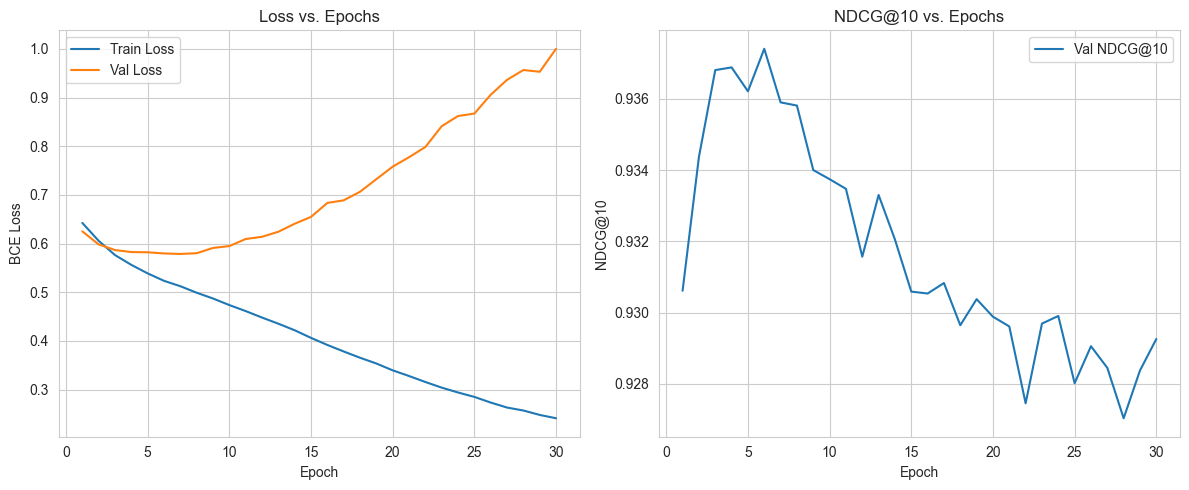

In [23]:
# Step 23: Analyzing Model Performance

best_epoch_stats = history_df.loc[history_df['ndcg@k'].idxmax()]
print("\n--- Performance of the Champion Ranking Model ---")
print(f"Best performance achieved at Epoch: {int(best_epoch_stats['epoch'])}")
print(f"  - Validation NDCG@10:      {best_epoch_stats['ndcg@k']:.4f}")
print(f"  - Validation Precision@10: {best_epoch_stats['precision@k']:.4f}")
print(f"  - Validation Recall@10:    {best_epoch_stats['recall@k']:.4f}")

# Plot the full training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
plt.title('Loss vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('BCE Loss'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_df['epoch'], history_df['ndcg@k'], label='Val NDCG@10')
plt.title('NDCG@10 vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('NDCG@10'); plt.legend()
plt.tight_layout(); plt.show()

In [24]:
# Step 24: FAISS Search Sanity Check

# This cell verifies that the FAISS index is working correctly by finding similar items
# for a known book title. It is self-contained and can run after a fresh kernel restart.

import os
import pickle
from pathlib import Path

import faiss
import numpy as np
import pandas as pd
import polars as pl

# Ensure PROCESSED_DATA_DIR is available even if the notebook kernel was just restarted
if 'PROCESSED_DATA_DIR' not in globals():
    PROCESSED_DATA_DIR = Path(os.getenv("PROCESSED_DATA_DIR", "./data/processed/"))

# Lazily load required assets if missing (fresh kernel scenarios)
if 'encoders' not in globals():
    with open(os.path.join(str(PROCESSED_DATA_DIR), "encoders.pkl"), "rb") as f:
        encoders = pickle.load(f)
if 'books' not in globals():
    books = pl.read_parquet(os.path.join(str(PROCESSED_DATA_DIR), "books_final.parquet"))
if 'model_df' not in globals():
    model_df = pl.read_parquet(os.path.join(str(PROCESSED_DATA_DIR), "model_df_final.parquet"))

index_path = os.path.join(str(PROCESSED_DATA_DIR), "faiss_index.bin")

try:
    index = faiss.read_index(index_path)
    print(f"Successfully loaded COLLABORATIVE FAISS index with {index.ntotal} vectors from '{index_path}'.")
except Exception as e:
    print(f"Error loading faiss_index.bin from '{index_path}': {e}")
    raise

# Create lookup maps to translate between different ID types
idx_to_work_id = encoders['work_id'].inverse_transform(np.arange(index.ntotal))
work_id_to_title = books.select(["work_id", "canonical_title"]).unique(subset=['work_id']).to_pandas().set_index('work_id')
idx_to_title = {i: work_id_to_title.loc[work_id]['canonical_title'] for i, work_id in enumerate(idx_to_work_id)}

# Select a book to query
query_title = "The Hobbit"
query_work_id_encoded = None

try:
    query_work_id_encoded = model_df.filter(pl.col("canonical_title") == query_title).select("work_id_encoded").row(0)[0]
    print(f"\nPerforming search for query book: '{query_title}' (work_id_encoded: {query_work_id_encoded})")
except IndexError:
    print(f"Error: Could not find '{query_title}' in the model's core vocabulary.")

if query_work_id_encoded is not None:
    # Reconstruct the query vector directly from the FAISS index for robustness
    query_vector = np.array([index.reconstruct(int(query_work_id_encoded))])
    
    # Use FAISS to find the nearest neighbors
    k = 11
    distances, indices = index.search(query_vector, k)
    result_indices = indices[0]
    result_distances = distances[0]
    
    # Display the results
    print("\n--- FAISS Search Results (Collaborative Similarity) ---")
    print("Index | Distance | Title")
    print("--------------------------------------------------")
    for i in range(k):
        idx = result_indices[i]
        dist = result_distances[i]
        title = idx_to_title.get(idx, "Unknown")
        print(f"{idx:<5} | {dist:<8.4f} | {title}")

Successfully loaded COLLABORATIVE FAISS index with 3169 vectors from 'data/processed/faiss_index.bin'.

Performing search for query book: 'The Hobbit' (work_id_encoded: 1569)

--- FAISS Search Results (Collaborative Similarity) ---
Index | Distance | Title
--------------------------------------------------
1569  | 0.0000   | The Hobbit
954   | 0.0667   | A Little Princess
1365  | 0.0746   | The Namesake
985   | 0.0768   | Lirael: Daughter of the Clayr
1253  | 0.0805   | Persuasion
229   | 0.0873   | The Little Prince
1804  | 0.0909   | The Slippery Slope
1758  | 0.0930   | On the Banks of Plum Creek
77    | 0.0965   | Joy Luck Club
1150  | 0.0973   | The Return of the King
923   | 0.0978   | Farewell to Arms


In [25]:
# Step 25: Save Final Assets for Dashboard

load_dotenv()
output_dir = os.getenv("PROCESSED_DATA_DIR", "data/processed")
os.makedirs(output_dir, exist_ok=True)

print(f"--- Saving all necessary assets ---")

# Ensure required assets exist even after a fresh kernel restart
try:
    import polars as _pl  # alias to avoid shadowing if imported
    import torch as _torch
    import pickle as _pickle
    import os as _os
    if 'books' not in globals() and _os.path.exists(_os.path.join(output_dir, "books_final.parquet")):
        books = _pl.read_parquet(_os.path.join(output_dir, "books_final.parquet"))
    if 'users' not in globals() and _os.path.exists(_os.path.join(output_dir, "users_final.parquet")):
        users = _pl.read_parquet(_os.path.join(output_dir, "users_final.parquet"))
    if 'ratings' not in globals() and _os.path.exists(_os.path.join(output_dir, "ratings_final.parquet")):
        ratings = _pl.read_parquet(_os.path.join(output_dir, "ratings_final.parquet"))
    if 'model_df' not in globals() and _os.path.exists(_os.path.join(output_dir, "model_df_final.parquet")):
        model_df = _pl.read_parquet(_os.path.join(output_dir, "model_df_final.parquet"))
    if 'encoders' not in globals() and _os.path.exists(_os.path.join(output_dir, "encoders.pkl")):
        with open(_os.path.join(output_dir, "encoders.pkl"), "rb") as _f:
            encoders = _pickle.load(_f)
    if 'user_history' not in globals() and _os.path.exists(_os.path.join(output_dir, "user_history.pkl")):
        with open(_os.path.join(output_dir, "user_history.pkl"), "rb") as _f:
            user_history = _pickle.load(_f)
    if 'title_embeddings' not in globals() and _os.path.exists(_os.path.join(output_dir, "title_embeddings.pt")):
        title_embeddings = _torch.load(_os.path.join(output_dir, "title_embeddings.pt"), map_location="cpu")
except Exception:
    pass

# 1. Create and save the definitive, portable config as a JSON file
print("Creating definitive model configuration from Optuna results...")
best_params = study_ranking.best_params
final_config_dict = {
    'EMBEDDING_DIM': best_params['embedding_dim'],
    'LEARNING_RATE': best_params['learning_rate'],
    'DROPOUT_RATE': best_params['dropout'],
    'N_LAYERS_USER': best_params['n_layers_user'],
    'N_LAYERS_ITEM': best_params['n_layers_item'],
    'EPOCHS': CONFIG.EPOCHS 
}
with open(os.path.join(PROCESSED_DATA_DIR, "config.json"), "w") as f:
    json.dump(final_config_dict, f, indent=4)
print("Definitive os.path.join(PROCESSED_DATA_DIR, 'config.json') saved successfully.")

# 2. Save all other data assets needed by the dashboard or for future analysis
books.write_parquet(os.path.join(output_dir, "books_final.parquet"))
users.write_parquet(os.path.join(output_dir, "users_final.parquet"))
ratings.write_parquet(os.path.join(output_dir, "ratings_final.parquet"))
model_df.to_pandas().to_parquet(os.path.join(output_dir, "model_df_final.parquet"))
with open(os.path.join(output_dir, "encoders.pkl"), "wb") as f: pickle.dump(encoders, f)
with open(os.path.join(output_dir, "user_history.pkl"), "wb") as f: pickle.dump(user_history, f)
torch.save(title_embeddings, os.path.join(output_dir, "title_embeddings.pt"))
print("All other data assets saved.")
print("\n--- All assets are now ready for the dashboard. ---")

--- Saving all necessary assets ---
Creating definitive model configuration from Optuna results...
Definitive os.path.join(PROCESSED_DATA_DIR, 'config.json') saved successfully.
All other data assets saved.

--- All assets are now ready for the dashboard. ---


In [26]:
# Step 26: Memory Optimization Utilities (Legacy)

# Note: This cell contains helper utilities for managing memory.
# It was likely used during development to optimize dataframes.
print("--- Memory Optimization and Caching Utilities ---")

class MemoryOptimizer:
    """Utility class for memory management and optimization."""
    @staticmethod
    def get_memory_usage():
        process = psutil.Process()
        return process.memory_info().rss / 1024 / 1024
    
    @staticmethod
    def clear_cache():
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    @staticmethod
    def optimize_dataframe(df):
        if isinstance(df, pl.DataFrame):
            df_pd = df.to_pandas()
            for col in df_pd.select_dtypes(include=['int64']).columns:
                df_pd[col] = pd.to_numeric(df_pd[col], downcast='integer')
            for col in df_pd.select_dtypes(include=['float64']).columns:
                df_pd[col] = pd.to_numeric(df_pd[col], downcast='float')
            return pl.from_pandas(df_pd)
        return df

class SmartCache:
    """Intelligent caching system for expensive operations."""
    def __init__(self, max_size=100):
        self.cache = {}
        self.max_size = max_size
        self.access_count = {}
    
    def _generate_key(self, *args, **kwargs):
        key_str = str(args) + str(sorted(kwargs.items()))
        return hashlib.md5(key_str.encode()).hexdigest()
    
    def get(self, key):
        if key in self.cache:
            self.access_count[key] = self.access_count.get(key, 0) + 1
            return self.cache[key]
        return None
    
    def set(self, key, value):
        if len(self.cache) >= self.max_size:
            lru_key = min(self.access_count.keys(), key=lambda k: self.access_count[k])
            del self.cache[lru_key]
            del self.access_count[lru_key]
        self.cache[key] = value
        self.access_count[key] = 1
    
    def cached_function(self, func):
        def wrapper(*args, **kwargs):
            key = self._generate_key(func.__name__, *args, **kwargs)
            result = self.get(key)
            if result is None:
                result = func(*args, **kwargs)
                self.set(key, result)
            return result
        return wrapper

# Global cache instance
cache = SmartCache(max_size=50)

def log_memory_usage(operation_name):
    memory_mb = MemoryOptimizer.get_memory_usage()
    print(f"Memory usage after {operation_name}: {memory_mb:.2f} MB")

# Apply optimization to the dataframes currently in memory
print("Optimizing existing dataframes for memory efficiency...")
if 'books' in locals():
    books = MemoryOptimizer.optimize_dataframe(books)
    log_memory_usage("books optimization")
if 'users' in locals():
    users = MemoryOptimizer.optimize_dataframe(users)
    log_memory_usage("users optimization")
if 'ratings' in locals():
    ratings = MemoryOptimizer.optimize_dataframe(ratings)
    log_memory_usage("ratings optimization")

print("Memory optimization utilities are ready.")

--- Memory Optimization and Caching Utilities ---
Optimizing existing dataframes for memory efficiency...
Memory usage after books optimization: 451.20 MB
Memory usage after users optimization: 566.17 MB
Memory usage after ratings optimization: 595.58 MB
Memory optimization utilities are ready.


In [27]:
# Step 22b: Building the SEMANTIC FAISS Index

# This index is for finding similar items based on their title embeddings.
# It MUST be built using the same core item vocabulary as the collaborative index.

print("\n--- Building the Semantic (Title-Based) FAISS Index ---")

# 1. Load the title embeddings for the CORE items
# These were generated in Step 17 and correspond to the 0-to-N-1 encoded work IDs.
try:
    core_title_embeddings = torch.load(os.path.join(PROCESSED_DATA_DIR, "title_embeddings.pt"), map_location='cpu')
    core_title_embeddings_np = core_title_embeddings.numpy().astype('float32')
    print(f"Loaded title embeddings for {core_title_embeddings_np.shape[0]} core items.")

    # 2. Build the FAISS index
    embedding_dim = core_title_embeddings_np.shape[1]
    semantic_index = faiss.IndexFlatL2(embedding_dim) # L2 distance is good for normalized embeddings

    # 3. Normalize and add the embeddings to the index
    faiss.normalize_L2(core_title_embeddings_np)
    semantic_index.add(core_title_embeddings_np)

    # 4. Save the index
    faiss.write_index(semantic_index, os.path.join(PROCESSED_DATA_DIR, os.path.join(PROCESSED_DATA_DIR, "semantic_faiss_index.bin")))
    print(f"Semantic FAISS index with {semantic_index.ntotal} items saved to os.path.join(PROCESSED_DATA_DIR, 'semantic_faiss_index.bin').")

except Exception as e:
    print(f"An error occurred while building the semantic FAISS index: {e}")


--- Building the Semantic (Title-Based) FAISS Index ---
Loaded title embeddings for 3169 core items.
An error occurred while building the semantic FAISS index: Error in faiss::FileIOWriter::FileIOWriter(const char *) at /Users/runner/work/faiss-wheels/faiss-wheels/third-party/faiss/faiss/impl/io.cpp:104: Error: 'f' failed: could not open data/processed/data/processed/semantic_faiss_index.bin for writing: No such file or directory


In [34]:
# Step 27: Definitive Smoke Tests

# This final cell provides a set of tests to ensure the entire recommendation system
# (asset loading, model inference, FAISS search, etc.) works end-to-end.

_ASSETS_CACHE = None
def get_assets():
    """Loads all necessary assets into a cached dictionary."""
    global _ASSETS_CACHE
    if _ASSETS_CACHE is None:
        print("--- Loading all assets for smoke test... ---")
        assets = {}
        
        # <<< FIX: Load the correct model config from the JSON file first!
        with open(os.path.join(PROCESSED_DATA_DIR, "config.json"), "r") as f: config_dict = json.load(f)
        MODEL_CONFIG = SimpleNamespace(**config_dict); MODEL_CONFIG.DEVICE = "cpu"

        with open(os.path.join(PROCESSED_DATA_DIR, "encoders.pkl"), "rb") as f: assets["encoders"] = pickle.load(f)
        with open(os.path.join(PROCESSED_DATA_DIR, "user_history.pkl"), "rb") as f: assets["user_history"] = pickle.load(f)
        assets["books"] = pl.read_parquet(os.path.join(PROCESSED_DATA_DIR, "books_final.parquet"))
        assets["users"] = pl.read_parquet(os.path.join(PROCESSED_DATA_DIR, "users_final.parquet"))
        assets["model_df_pd"] = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, "model_df_final.parquet"))
        assets["title_embeddings"] = torch.load(os.path.join(PROCESSED_DATA_DIR, "title_embeddings.pt"), map_location=MODEL_CONFIG.DEVICE)
        assets["collaborative_faiss_index"] = faiss.read_index(os.path.join(PROCESSED_DATA_DIR, "faiss_index.bin"))
        assets["semantic_faiss_index"] = faiss.read_index(os.path.join(PROCESSED_DATA_DIR, "semantic_faiss_index.bin"))
        vocab_sizes = {k: len(v.classes_) for k, v in assets["encoders"].items()}
        
        # <<< FIX: Use the loaded MODEL_CONFIG, not the global CONFIG
        model = FinalTwoTowerModel(vocab_sizes, assets["title_embeddings"].shape[1], MODEL_CONFIG)
        model.load_state_dict(torch.load(os.path.join(PROCESSED_DATA_DIR, "final_ranking_model.pth"), map_location=MODEL_CONFIG.DEVICE))
        assets["model"] = model.eval()
        assets["core_user_ids"] = set(assets["model_df_pd"]['user_id'].unique())
        _ASSETS_CACHE = assets
    return _ASSETS_CACHE
# Step 22b: Building the SEMANTIC FAISS Index

# This index is for finding similar items based on their title embeddings.
# It MUST be built using the same core item vocabulary as the collaborative index.

print("\n--- Building the Semantic (Title-Based) FAISS Index ---")

# 1. Load the title embeddings for the CORE items
# These were generated in Step 17 and correspond to the 0-to-N-1 encoded work IDs.
try:
    core_title_embeddings = torch.load(os.path.join(PROCESSED_DATA_DIR, "title_embeddings.pt"), map_location='cpu')
    core_title_embeddings_np = core_title_embeddings.numpy().astype('float32')
    print(f"Loaded title embeddings for {core_title_embeddings_np.shape[0]} core items.")

    # 2. Build the FAISS index
    embedding_dim = core_title_embeddings_np.shape[1]
    semantic_index = faiss.IndexFlatL2(embedding_dim) # L2 distance is good for normalized embeddings

    # 3. Normalize and add the embeddings to the index
    faiss.normalize_L2(core_title_embeddings_np)
    semantic_index.add(core_title_embeddings_np)

    # 4. Save the index
    faiss.write_index(semantic_index, os.path.join(PROCESSED_DATA_DIR, "semantic_faiss_index.bin"))
    print(f"Semantic FAISS index with {semantic_index.ntotal} items saved to os.path.join(PROCESSED_DATA_DIR, 'semantic_faiss_index.bin').")

except Exception as e:
    print(f"An error occurred while building the semantic FAISS index: {e}")
def get_recommendations(mode, user_id_str, book_title_str, k=5):
    """Main logic for generating recommendations based on the selected mode."""
    assets = get_assets()
    books_df = assets['books']
    core_user_ids = assets['core_user_ids']
    encoders = assets['encoders']
    info_text = ""
    work_ids = []

    if not mode: return "Please select a mode.", []

    if mode == "Recommend for User":
        user_id = int(user_id_str) if user_id_str else None
        if not user_id: return "Please select a User ID.", []

        if user_id in core_user_ids:
            # Core User Logic (Personalized Recs)
            info_text = f"Showing personalized recommendations for Core User {user_id}."
            user_tower = assets['model'].user_tower
            user_id_encoded = encoders['user_id'].transform([user_id])[0]
            user_features_row = assets['model_df_pd'][assets['model_df_pd']['user_id_encoded'] == user_id_encoded].iloc[0]
            features = {'user_id': torch.tensor([user_id_encoded]), 'age_bin': torch.tensor([user_features_row['age_bin_encoded']]), 'country': torch.tensor([user_features_row['country_encoded']])}
            with torch.no_grad(): user_embedding = user_tower(features).cpu().numpy()
            faiss.normalize_L2(user_embedding)
            search_k = k + len(assets['user_history'].get(user_id, set()))
            distances, indices = assets['collaborative_faiss_index'].search(user_embedding, search_k)
            recommended_ids_encoded = [idx for idx in indices[0] if idx not in assets['user_history'].get(user_id_encoded, set())]
            work_ids = encoders['work_id'].inverse_transform(recommended_ids_encoded)
        else:
            # Cold Start User Logic (Popularity Fallback)
            info_text = f"Showing most popular books for Cold Start User {user_id}."
            ratings_df = pl.read_parquet(os.path.join(PROCESSED_DATA_DIR, "ratings_final.parquet"))
            work_ids = ratings_df['work_id'].value_counts().sort('count', descending=True).head(k)['work_id'].to_list()

    elif mode == "Find Similar Items":
        if not book_title_str: return "Please select a book title.", []
        query_book = books_df.filter(pl.col('canonical_title') == book_title_str)
        if query_book.is_empty(): return f"Book '{book_title_str}' not found.", []
        
        query_work_id = query_book['work_id'][0]
        query_author = query_book['canonical_author'][0]
        info_text = f"Showing items similar to '{book_title_str}'."

        core_work_ids = set(encoders['work_id'].classes_)
        if query_work_id in core_work_ids:
            # Core Item Logic (Semantic Similarity)
            work_id_encoded = encoders['work_id'].transform([query_work_id])[0]
            query_vector = assets['title_embeddings'][work_id_encoded:work_id_encoded+1].cpu().numpy()
            distances, indices = assets['semantic_faiss_index'].search(query_vector, k + 1)
            similar_ids_encoded = [idx for idx in indices[0] if idx != work_id_encoded]
            work_ids = encoders['work_id'].inverse_transform(similar_ids_encoded)
        else:
            # Cold Start Item Logic (Author-based Fallback)
            info_text += f"\n(This is a Cold Start item, showing other books by {query_author})."
            author_recs = books_df.filter((pl.col('canonical_author') == query_author) & (pl.col('work_id') != query_work_id))
            work_ids = author_recs.head(k)['work_id'].to_list()

    if hasattr(work_ids, '__len__') and len(work_ids) > 0:
        final_work_ids = list(work_ids)[:k]
        rec_books_all_editions = books_df.filter(pl.col('work_id').is_in(final_work_ids))
        rec_books_unique = rec_books_all_editions.unique(subset=['work_id'], keep='first')
        order_map = {work_id: i for i, work_id in enumerate(final_work_ids)}
        rec_books_list = rec_books_unique.to_dicts()
        rec_books_list.sort(key=lambda b: order_map.get(b['work_id'], float('inf')))
        gallery_output = [(row['image_m'], f"{row['canonical_title']}\nby {row['canonical_author']}") for row in rec_books_list]
        return info_text, gallery_output

    return info_text, []

def run_smoke_test():
    print("\n" + "="*50); print("--- RUNNING DEFINITIVE SMOKE TESTS ---"); print("="*50)
    
    def test_and_print(mode, user_id, title):
        info, gallery = get_recommendations(mode, user_id, title, k=5)
        print(f"Status: {info}")
        if len(gallery) > 0:
            for i, item in enumerate(gallery): print(f"  {i+1}. {item[1].replace('//n',' ')}")
        else:
            print("  -> No recommendations generated.")

    assets = get_assets()
    
    print(f"\n[TEST 1] Recommendations for CORE User: 638")
    test_and_print("Recommend for User", "638", None)
    
    print(f"\n[TEST 2] Recommendations for COLD START User: 1")
    test_and_print("Recommend for User", "1", None)
    
    core_work_ids = set(assets['encoders']['work_id'].classes_)
    core_books_df = assets['books'].filter(pl.col('work_id').is_in(core_work_ids))
    core_item_title = core_books_df['canonical_title'][0]
    print(f"\n[TEST 3] Similar Items for CORE book: '{core_item_title}'")
    test_and_print("Find Similar Items", None, core_item_title)
        
    cold_books_df = assets['books'].filter(~pl.col('work_id').is_in(core_work_ids))
    cold_item_title = cold_books_df['canonical_title'][0]
    print(f"\n[TEST 4] Similar Items for COLD START book: '{cold_item_title}'")
    test_and_print("Find Similar Items", None, cold_item_title)

# Run the final tests
run_smoke_test()


--- Building the Semantic (Title-Based) FAISS Index ---
Loaded title embeddings for 3169 core items.
Semantic FAISS index with 3169 items saved to os.path.join(PROCESSED_DATA_DIR, 'semantic_faiss_index.bin').

--- RUNNING DEFINITIVE SMOKE TESTS ---
--- Loading all assets for smoke test... ---

[TEST 1] Recommendations for CORE User: 638
Status: Showing personalized recommendations for Core User 638.
  1. The Hearing
by John Lescroart
  2. The Kitchen God's Wife
by Amy Tan
  3. Mystic River
by Dennis Lehane
  4. Dilbert: A Book of Postcards
by Scott Adams
  5. Invisible Man
by Ralph Ellison

[TEST 2] Recommendations for COLD START User: 1
Status: Showing most popular books for Cold Start User 1.
  1. The Lovely Bones: A Novel
by Alice Sebold
  2. Wild Animus
by Rich Shapero
  3. The Da Vinci Code
by DAN BROWN
  4. The Secret Life of Bees
by Sue Monk Kidd
  5. The Red Tent : A Novel
by Anita Diamant

[TEST 3] Similar Items for CORE book: 'Little Women'
Status: Showing items similar to '

In [32]:
ratings

user_id,work_id,rating,rating_count
i32,u32,i8,u32
229632,65569,5,1
71514,80086,5,1
276521,84147,5,1
57002,157292,10,1
11245,125837,8,1
…,…,…,…
44252,12968,10,1
170947,92525,9,1
169779,48078,7,1
